Welcome to the **Explainer Notebook for Project Assigment B** in the class [02805 Social Graphs and Interactions](https://kurser.dtu.dk/course/02805) offered by DTU in the Fall 2020. You can also have a look at our: 

[Github](https://github.com/s153748/s153748.github.io) | [Webpage](https://s153748.github.io/) | [Video](https://www.youtube.com/watch?v=wJykfm2wims&ab_channel=LiseStyve)

We follow a general outline covering the [required deliverables](https://github.com/SocialComplexityLab/socialgraphs2020/wiki/Project-Assignments#project-assignment-b):
1. Motivation
    * Purpose
    * Dataset
2. Basic stats
    * Data preprocessing and cleaning
    * Exploratory data analysis
3. Tools, theory and analysis
    * Network analysis
    * Development and trends
    * Community analysis
4. Discussion
5. Contributions

# 1 Motivation
*Description of dataset and why we chose it, goal for the end user's experience*

*Purpose*

GitHub is where over 50 million developers shape the future of software, together. The site provides hosting for software development, version control using Git and several collaboration features. As of January 2020, GitHub reports having over 40 million users and more than 190 million repositories (including at least 28 million public repositories), making it the largest host of source code in the world [[1]](https://en.wikipedia.org/wiki/GitHub).

The aim of our project is to analyze the social network of GitHub users. We limit our focus to profiles related to the topic of machine learning, which has huge potential and untapped possibilities [[2]](https://www.forbes.com/sites/forbestechcouncil/2020/03/24/machine-learning-the-real-buzzword-of-2020/?sh=1fb640c13ea7). We will analyze the network with the purpose of answering the main questions:
1. How are the users connected?
    - Connectivity, hubs, communities and spatial connections in the network
2. What are the most popular languages?
    - Find top programming languages for netowork and communities
3. How is the vibe in the coding communities? 
    - Sentiment analysis of user bios and repository descriptions
4. What users are worth following?
    - Based on followers, stars, forks, repositories, activity and topics

Finally, we will present our findings from the network and text analysis using interactive visualizations hosted on a [GitHub webpage](https://s153748.github.io/). The goal for the end user experience is to provide an overview of the Github network and its characteristics though answerering the above questions. Further, we want the user to be able to explore the graph of the network and its communities in different ways in order to learn more about the top machine learning developers and be inspired. 

*Dataset*

When we first searched for machine learning on GitHub, it resulted in 277,787 repositories, 9,588,021 available codes, 258,336 commits, 110,957 issues, 47,434 users and 31,396 wikis. So there is more than enough data to work with. We decide to scrape data from the owners as well as the top contributers of the top repositories matching our search.

In order to gather data from the GitHub API, we generate a [GitHub access token](https://docs.github.com/en/free-pro-team@latest/github/authenticating-to-github/creating-a-personal-access-token) and use the tools `PyGithub`, `Requests` and `Beautiful Soup`. The scraping results in a 297.2+ KB dataset of 1585 distinct users as rows and 23 data variables as columns. The data variables obtained from the user profiles are:
* `user_name` - user name
* `name` - full name
* `bio` - biography
* `email` - email 
* `location` - location
* `company` - company
* `hireable` - whether the user is hireable or not (true/false)
* `blog` - blog url
* `created_at` - date and time the user was created
* `updated_at` - date and time the user was updated
* `followers_count` - number of followers
* `following_count` - number of users the user is following

Further, the variabels obtained from the user’s repositories are:
* `repos` - name of repository the user is extracted from
* `owner` - name of the owner of the repository the user is extracted from
* `description` - of repository the user is extracted from
* `repos_count` - number of repositories per user
* `repos_name` - name of all repositories per user
* `total_stars` - count of stars of repositories per user
* `total_forks` - count of forks of repositories per user
* `main_language` - the language used the most in the user's repositories
* `used_languages` - all languages used in the user's repositories

The dataset is available for [download](https://github.com/s153748/s153748.github.io).

# 2. Basic stats
*Understand dataset better, choices in data cleaning and preprocessing, discuss the dataset stats (recycle the work for Project Assignment A)*

## 2.1 Data preprocessing and cleaning

### 2.1.1 Imports

In [412]:
import pandas as pd
import numpy as np

from urllib.request import urlopen
import requests
import re
import ast 
from bs4 import BeautifulSoup
import json
import os
import string  
import math

import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
from seaborn import color_palette
import networkx as nx
import community
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from fa2 import ForceAtlas2
from PIL import Image, ImageFont
import collections

import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from ipywidgets import widgets
from googletrans import Translator
import altair as alt 
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm

import folium
from folium import FeatureGroup, LayerControl, plugins, Map, Marker
from folium.plugins import FastMarkerCluster, MarkerCluster
import branca
import branca.colormap as cm
from branca.colormap import linear

import warnings
warnings.filterwarnings('ignore')

### 2.1.2 Data scraping 
*Note that this section should not be ran, as it takes a long time.*

In [413]:
# Github access token to retrieve data from the API
token = '6e6ed3141ba89c97fd3ddce3d118a2ac53a0fc85'
headers = {'Authorization': 'token ' + token}

### 2.1.3 Load data

In [414]:
# define missing value types
missing_values = ['na', 'n/a', '-', '--']

# load scraped data
df = pd.read_csv('data/final_data.csv', converters={'following': eval,'repos_name': eval}, index_col=0, na_values = missing_values)

# display dataframe
df.head(3)

user_name         owner                                    repos  \
0  josephmisiti  josephmisiti                 awesome-machine-learning   
1          wepe          wepe                          MachineLearning   
2       ZuzooVn       ZuzooVn  machine-learning-for-software-engineers   

            name  type         company        location  \
0  Joseph Misiti  User  Math & Pencil     Brooklyn, NY   
1          wepon  User          AntFin  China Hangzhou   
2         Nam Vu  User             NaN         Vietnam   

                                                 bio            created_at  \
0        Mathematician & Co-founder of Math & Pencil  2010-04-17T21:09:13Z   
1                                                NaN  2014-10-10T14:28:18Z   
2  A Vietnamese Software Engineer who is really p...  2012-02-11T16:55:02Z   

             updated_at  ...              email followers_count  \
0  2020-10-29T18:11:39Z  ...                NaN            2610   
1  2020-11-05T15:54:10Z  ...   wepon@pku.edu.cn            4564   
2  2020-10-12T02:40:45Z  ...  zuzoovn@gmail.com            1223   

  following_count hireable  repos_count  \
0             275     True          226   
1              47      NaN           27   
2              91     True           38   

                                          repos_name total_stars  total_forks  \
0  [80s.nyc, alexa-skills-kit-js, algodeck, algor...       48727        12605   
1  [AliTianChi, CaiNiao-DemandForecast-StoragePla...        7324         5193   
2  [android-classyshark, asi-http-request, awesom...       24471         5838   

  main_language                                     used_languages  
0        Python  ['C' 'C++' 'CSS' 'CoffeeScript' 'Go' 'HTML' 'J...  
1        Python             ['C++' 'HTML' 'Java' 'Python' 'Shell']  
2        Python  ['C' 'DIGITAL Command Language' 'HTML' 'Java' ...  

[3 rows x 23 columns]

In [415]:
# get info such as shape, data types, column names, memory usage
print(df.shape)
df.info()

(1585, 23)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1585 entries, 0 to 1584
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_name        1585 non-null   object
 1   owner            1585 non-null   object
 2   repos            1585 non-null   object
 3   name             1345 non-null   object
 4   type             1585 non-null   object
 5   company          767 non-null    object
 6   location         1008 non-null   object
 7   bio              691 non-null    object
 8   created_at       1585 non-null   object
 9   updated_at       1585 non-null   object
 10  following        1585 non-null   object
 11  description      1542 non-null   object
 12  blog             752 non-null    object
 13  email            620 non-null    object
 14  followers_count  1585 non-null   int64 
 15  following_count  1585 non-null   int64 
 16  hireable         364 non-null    object
 17  repos_count      1585 

In [416]:
# convert the used_languages to a list of strings
df['used_languages'] = df['used_languages'].str.replace(' ',',').str.replace('\n','').str.replace("'","")
def stringToList(colname):
    df[colname] = [df[colname][i][1:len(df[colname][i])-1].split(',') for i in range(len(df))]
stringToList('used_languages')

# create additional variable for 'following' with only the users that exist in the 'user_name' variable already
df['following_relevant'] = ''
for i in range(len(df)):
    df['following_relevant'][i] = np.unique([link for link in df['following'][i] if link in df['user_name'].values])

In [417]:
# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(f'Numeric variables:\n {numeric_cols}')

# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(f'Non-numeric variables:\n {non_numeric_cols}')

Numeric variables:
 ['followers_count' 'following_count' 'repos_count' 'total_stars'
 'total_forks']
Non-numeric variables:
 ['user_name' 'owner' 'repos' 'name' 'type' 'company' 'location' 'bio'
 'created_at' 'updated_at' 'following' 'description' 'blog' 'email'
 'hireable' 'repos_name' 'main_language' 'used_languages'
 'following_relevant']


### 2.1.4 Missing data

In [418]:
# find number of missing values
print(f'Total number of missing values: {df.isnull().sum().sum()}')

Total number of missing values: 5647


In [419]:
# find missing values for each variable
print('Total number of missing values per variable:')
df.isnull().sum()

Total number of missing values per variable:


user_name                0
owner                    0
repos                    0
name                   240
type                     0
company                818
location               577
bio                    894
created_at               0
updated_at               0
following                0
description             43
blog                   833
email                  965
followers_count          0
following_count          0
hireable              1221
repos_count              0
repos_name               0
total_stars              0
total_forks              0
main_language           56
used_languages           0
following_relevant       0
dtype: int64

In [420]:
# find percentage of missing values
print('Missing data percentages:\n')
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    if pct_missing > 0:
        print('{} - {}%'.format(col, round(pct_missing*100)))

Missing data percentages:

name - 15.0%
company - 52.0%
location - 36.0%
bio - 56.0%
description - 3.0%
blog - 53.0%
email - 61.0%
hireable - 77.0%
main_language - 4.0%


In [421]:
# define colors for plotting
blue = ['#f7fbff','#79b8ff','#0366d6','#044289','#05264c','#191970']

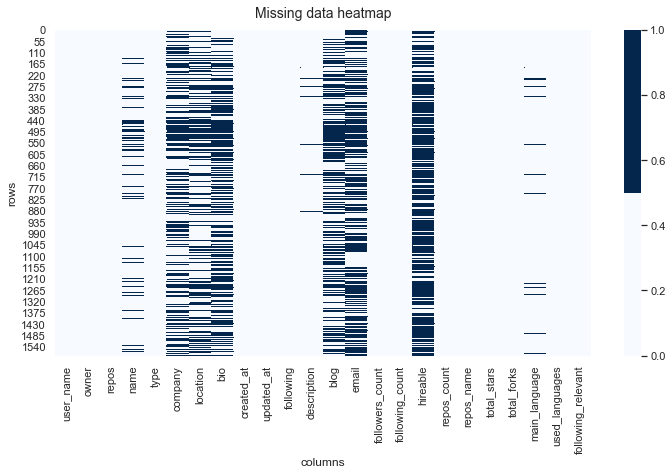

In [422]:
# visualize the missing data with a heatmap
sns.set()
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df[df.columns].isnull(), cmap=sns.color_palette([blue[0], blue[4]]))
heatmap.set_title('Missing data heatmap', fontsize=14, pad=12)
heatmap.set_xlabel('columns')
heatmap.set_ylabel('rows')
plt.show()

The percentages of missing data and the heatmap demonstrates the missing data patterns of the 24 variables. The dark blue color represents the missing data, as opposed to the light blue color representing data that is not missing. It is seen that the variables `name`, `company`, `location`, `bio`, `blog`, `email` and `hirable` have missing values throughout many rows, whereas `description` and `main_language` only has a few missing values. There seem to be no missing values for the numeric variables. We notice that the `hireable` variable has as much as 77 % of missing data indicating we should remove this variable.

In [423]:
# drop variables with a lot of missing data
df = df.drop('hireable', axis=1)

# update
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

We now identify the missing values situations among the 1585 observations.

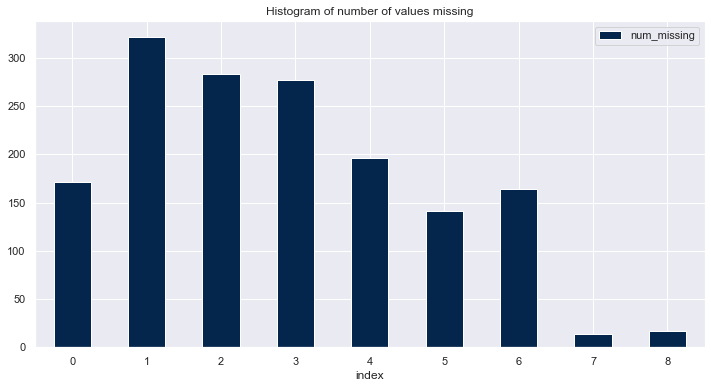

In [424]:
# first create missing indicator for variables with missing data
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    if num_missing > 0:  
        df['{}_ismissing'.format(col)] = missing

# based on the indicator, plot the histogram of missing values
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)
sns.set()
df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(
    x='index', y='num_missing', figsize=(12, 6), color=blue[4], title='Histogram of number of values missing')
plt.xticks(rotation=0)
plt.show()

It is seen that there are about 60 observations with no missing values and close to 300 observations with two missing values. We decide not to remove any of the observations, since none of them have more than 9 missing values (out of 24), which means there are still a lot of useful data from the remaining values that are not missing.

To handle the missing data of the categorical values, we have different options:
* Drop the missing values
* Replace missing values with the mode (the most frequent value) of the data that is not missing
* Fill missing values with empty strings "" indicating the data is missing

Since we don't want to want to keep as much information as possible while not "manipulating" the results, we choose the last option.  

In [425]:
for col in non_numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    if num_missing > 0:
        print('Filling missing values for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing
        df[col] = df[col].fillna('')

Filling missing values for: name
Filling missing values for: company
Filling missing values for: location
Filling missing values for: bio
Filling missing values for: description
Filling missing values for: blog
Filling missing values for: email
Filling missing values for: main_language


In [426]:
# drop columns used to detect missing values
cols_to_drop = ['num_missing', 'name_ismissing', 'company_ismissing', 'location_ismissing', 'bio_ismissing',
                'description_ismissing', 'blog_ismissing', 'email_ismissing', 'main_language_ismissing']
df = df.drop(cols_to_drop, axis=1)

# update
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

In [427]:
# any missing values?
df.isnull().values.any()

False

### 2.1.5 Unnecessary data
The aim is now to find unnecessary data that does not add value because it is uninformative, duplicate, repetitive or irrelevant.

In [428]:
# check for duplicates
try: 
    df.drop('user_name', axis=1).drop_duplicates()
except:
    print('No duplicates found')

No duplicates found


In [429]:
# find percentage of the same value for each variable
repetitive_cols = []
for col in df.columns:
    top_pct = (df[col].value_counts()/len(df.index)).iloc[0]
    print('{0}: {1:.1f}%'.format(col, top_pct*100))
    if top_pct > 0.5:
        repetitive_cols.append(col)

user_name: 0.1%
owner: 10.0%
repos: 6.3%
name: 15.1%
type: 100.0%
company: 51.6%
location: 36.4%
bio: 56.4%
created_at: 0.1%
updated_at: 0.1%
following: 31.2%
description: 2.7%
blog: 52.6%
email: 60.9%
followers_count: 9.9%
following_count: 31.2%
repos_count: 3.4%
repos_name: 2.1%
total_stars: 25.6%
total_forks: 28.6%
main_language: 42.1%
used_languages: 3.5%
following_relevant: 1.1%


In [430]:
# look at the top values of the most repetitive variables
for col in repetitive_cols:
    display(df[col].value_counts()[:5])

User    1585
Name: type, dtype: int64

              818
Microsoft      57
Google         36
Amazon         14
@Microsoft     13
Name: company, dtype: int64

                             894
Data Scientist                 4
Software Engineer              4
Google Brain                   2
Machine Learning Engineer      2
Name: bio, dtype: int64

                            833
https://aws.amazon.com        2
http://www.microsoft.com      2
https://aws.amazon.com/       2
http://viralfsharp.com        2
Name: blog, dtype: int64

                                                                      965
hangzh@microsoft.com                                                    1
chris.schmich+remove-this-if-youre-not-a-bot@agilitycollective.com      1
Tommy.chaoping.li@ibm.com                                               1
maiyo.elton@gmail.com                                                   1
Name: email, dtype: int64

The variable `type` has only one distinct value, that is user, and is thus 100 % repetitive. Since all observations have the same type, this variable does not contribute with any value and can be removed from the dataset. 

For the other repetitive variables, a lot of values that are blank representing the information was not provided. For example, `email` has 60.9 % of its values as blank, meaning the email was not provided by the GitHub user, whereas the rest of the values are unique emails. Since the values of the variables are not very repetitive besides from the blanks, we decide to keep them. 

In [431]:
# drop the variable 'type'
df = df.drop('type', axis=1)

# update
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

### 2.1.6 Inconsistent data
Though looking at the repetitive values above, we spot that both Microsoft and @Microsoft was on the list of companies, suggesting we should remove the '@'. We expect a lot of different punctuations and have look at distinct values to detect which we want to remove, as we want to keep the '&' in the company Math & Pencil for example. 

We clean the variables `company` and `location` by removing selected punctuations, converting the text to lower case and stripping for blanks. The variables `description` and `bio` with larger amounts of text will be cleaned for the purpose of the sentiment analysis in Section 3.5. 

In [432]:
np.unique(df['company'])

array(['', ' https://github.com/google', '&Ranj', '.NET Foundation',
       '140.113.0.0', '2021 应届生｜Alibaba',
       '84.51°; Wright State University; University of Cincinnati; @koalaverse ',
       '@15five ', '@1Password', '@1debit ', '@AWS', '@Arrikto',
       '@Azure ', '@BingusDingo ', '@BlockSigner ', '@Bytedance',
       '@CSCfi ', '@CiscoAI ', '@Comcast ', '@ContinuumIO', '@DevFactory',
       '@Dropbox', '@ESA_DataScience', '@EnzymeCorp ', '@EpisourceLLC',
       '@EpistasisLab', '@EthicalML @SeldonIO ', '@Evomo',
       '@FormidableLabs', '@GetStream @yesfeedme @exercism @gofrs ',
       '@GitbookIO ', '@GoDataDriven', '@Google', '@Gradiant', '@Huawei',
       '@IBM', '@IBM - @CODAIT', '@IDeliverable ', '@LITrans',
       '@MateLabs ', '@MegEngine', '@Meituan-Dianping', '@MichiganNLP',
       '@Microsoft', '@Microsoft ', '@Microsoft @dotnet ',
       '@MindOrksOpenSource', '@NVIDIA',
       '@NeatNait @TribalScale @JSarmy ', '@Neuraxio', '@ONE-LOGIC ',
       '@OpenMined @Hy

In [433]:
np.unique(df['location'])

array(['', ' india', '/dev/tcp/127.0.0.1/443', '0x7ffffffeffff',
       '127.0.0.1', 'Aberdeen, UK', 'Aberdeen, United Kingdom',
       'Adelaide', 'Adelaide, Australia',
       'Albacete, Castilla-La Mancha, Spain', 'Alexandria, Egypt',
       'Algeria', 'Almaty, Kazakhstan', 'Amherst', 'Amherst, MA',
       'Amritsar', 'Amsterdam', 'Amsterdam ', 'Amsterdam, Netherlands',
       'Ann Arbor', 'Ann Arbor, MI, USA', 'Arlington, VA', 'Ashburn, VA',
       'Asheville, NC, USA', 'Athens', 'Athens, Greece', 'Athens, Ohio',
       'Atlanta, GA', 'Atlanta, Georgia', 'Auckland, New Zealand',
       'Augsburg', 'Austin, TX', 'Australia', 'Austria', 'BUPT',
       'Bangalore', 'Bangalore India', 'Bangalore, India',
       'Bansko, Bulgaria', 'Barcelona', 'Barcelona, Spain',
       'Bavaria, Germany', 'Bay Area', 'Bay Area, California',
       'Bay Area, California, USA', 'Beijing', 'Beijing, CN',
       'Beijing, China', 'Beijing, China ', 'Beijing, China.',
       'Belarus, Minsk', 'Belgium', 'B

In [434]:
def remove_punctuation(text):
    punctuation = '!"#$%\'()*+,./:;<=>?@[\\]^_`´{|}~¨°⇄·'
    no_punct = [words for words in text if words not in punctuation]
    words_wo_punct = ''.join(no_punct)
    return words_wo_punct

df['company'] = df['company'].str.lower().str.strip().apply(lambda x: remove_punctuation(x))
df['location'] = df['location'].str.lower().str.strip().apply(lambda x: remove_punctuation(x))

# remove selected non-meaningful values
inconsistent = ['0x7ffffffeffff', '127001', '14011300', 'devtcp127001443', 'vault 0 ⇌ br ⇌ es ⇌ us']
for word in inconsistent:
    df['company'] = df['company'].replace(word,'')
    df['location'] = df['location'].replace(word,'')

We make sure the format of the datetime variables are correct and create additional variables for year, month and day, that is easier to work with in the analysis. 

In [435]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d')
df['created_at_year'] = df['created_at'].dt.year
df['created_at_month'] = df['created_at'].dt.month
df['created_at_weekday'] = df['created_at'].dt.weekday

df['updated_at'] = pd.to_datetime(df['updated_at'], format='%Y-%m-%d')
df['updated_at_year'] = df['updated_at'].dt.year
df['updated_at_month'] = df['updated_at'].dt.month
df['updated_at_weekday'] = df['updated_at'].dt.weekday


user_name         owner                                    repos  \
0  josephmisiti  josephmisiti                 awesome-machine-learning   
1          wepe          wepe                          MachineLearning   
2       ZuzooVn       ZuzooVn  machine-learning-for-software-engineers   

            name        company        location  \
0  Joseph Misiti  math & pencil     brooklyn ny   
1          wepon         antfin  china hangzhou   
2         Nam Vu                        vietnam   

                                                 bio  \
0        Mathematician & Co-founder of Math & Pencil   
1                                                      
2  A Vietnamese Software Engineer who is really p...   

                 created_at                updated_at  \
0 2010-04-17 21:09:13+00:00 2020-10-29 18:11:39+00:00   
1 2014-10-10 14:28:18+00:00 2020-11-05 15:54:10+00:00   
2 2012-02-11 16:55:02+00:00 2020-10-12 02:40:45+00:00   

                                           following  ... total_forks  \
0  [mojombo, defunkt, vanpelt, macournoyer, ry, b...  ...       12605   
1  [pluskid, benanne, colah, kennethreitz42, karp...  ...        5193   
2  [ole, escoz, pokeb, tcdoan, dyang, kirill-grou...  ...        5838   

  main_language                                     used_languages  \
0        Python  [C, C++, CSS, CoffeeScript, Go, HTML, Java, Ja...   
1        Python                   [C++, HTML, Java, Python, Shell]   
2        Python  [C, DIGITAL, Command, Language, HTML, Java, Ja...   

                                  following_relevant  created_at_year  \
0  [JWarmenhoven, agramfort, alextp, amueller, ba...             2010   
1    [aymericdamien, enjoyhot, guolinke, junlulocky]             2014   
2                                          [jwasham]             2012   

   created_at_month created_at_weekday  updated_at_year  updated_at_month  \
0                 4                  5             2020                10   
1                10                  4             2020                11   
2                 2                  5             2020                10   

  updated_at_weekday  
0                  3  
1                  3  
2                  0  

[3 rows x 28 columns]

### 2.1.7  Adding geo locations

In this part, we infer the GPS coordinates (longitude and latitude) from the `location` variable in the dataset. This will enable the creating of a graph based on geographic position of each user. 

We use the Python client for geocoding web services [GeoPy](https://geopy.readthedocs.io/en/stable/#module-geopy.extra.rate_limiter) together with the geolocator [OpenStreetMap Nominatim](https://nominatim.openstreetmap.org/ui/search.html), which allows us to look up a location's GPS coordinates from a textual description. It has its own class in `geopy.geocoders` abstracting the API.

Finding the geolocations takes some time due to [limitations](https://operations.osmfoundation.org/policies/nominatim/), so the following piece of code should not be ran. A delay of 1 second (`min_delay_seconds`=1) is used between each pair of `geolocator.geocode` calls. 

In [452]:
# load location data
location_df = pd.read_csv('data/location_data.csv', converters={'following': eval,'repos_name': eval, "coordinates": ast.literal_eval}, index_col=0)

location_df['following_relevant_loc'] = ''
for i in range(len(location_df)):
    try:
        location_df['following_relevant_loc'][i] = np.unique([link for link in location_df['following'][i] if link in location_df['user_name'].values])
    except: 
        location_df['following_relevant_loc'][i] = []
        
# display dataframe
location_df.head(3)

user_name         owner                                    repos  \
0  josephmisiti  josephmisiti                 awesome-machine-learning   
1          wepe          wepe                          MachineLearning   
2       ZuzooVn       ZuzooVn  machine-learning-for-software-engineers   

            name        company        location  \
0  Joseph Misiti  math & pencil     brooklyn ny   
1          wepon         antfin  china hangzhou   
2         Nam Vu            NaN         vietnam   

                                                 bio  \
0        Mathematician & Co-founder of Math & Pencil   
1                                                NaN   
2  A Vietnamese Software Engineer who is really p...   

                  created_at                 updated_at  \
0  2010-04-17 21:09:13+00:00  2020-10-29 18:11:39+00:00   
1  2014-10-10 14:28:18+00:00  2020-11-05 15:54:10+00:00   
2  2012-02-11 16:55:02+00:00  2020-10-12 02:40:45+00:00   

                                           following  ... created_at_month  \
0  [mojombo, defunkt, vanpelt, macournoyer, ry, b...  ...                4   
1  [pluskid, benanne, colah, kennethreitz42, karp...  ...               10   
2  [ole, escoz, pokeb, tcdoan, dyang, kirill-grou...  ...                2   

  created_at_weekday updated_at_year  updated_at_month  updated_at_weekday  \
0                  5            2020                10                   3   
1                  4            2020                11                   3   
2                  5            2020                10                   0   

                 coordinates  \
0  (40.6501038, -73.9495823)   
1  (30.2489634, 120.2052342)   
2  (13.2904027, 108.4265113)   

                                             address   longitude   latitude  \
0  Brooklyn, Kings County, New York, United State...  -73.949582  40.650104   
1                            杭州市, 江干区, 浙江省, China 中国  120.205234  30.248963   
2                                           Việt Nam  108.426511  13.290403   

                              following_relevant_loc  
0  [JWarmenhoven, agramfort, alextp, amueller, ba...  
1                [aymericdamien, enjoyhot, guolinke]  
2                                          [jwasham]  

[3 rows x 33 columns]

We add a variable `continent` based on whether the coordinates are within the borders of continents of the world. The borders are found using [boxfinder](http://bboxfinder.com/).

In [511]:
location_df['continent'] = ""
for idx, row in location_df.iterrows():
    if row['latitude'] < 70 and row['latitude'] > 27 and row['longitude'] < 40 and row['longitude'] > -25:
        location_df['continent'][idx] = 'Europe'
    elif row['latitude'] < 43 and row['latitude'] > 0 and row['longitude'] < 160 and row['longitude'] > 70:
        location_df['continent'][idx] = 'Asia' 
    elif row['latitude'] < 58 and row['latitude'] > -25 and row['longitude'] < 36 and row['longitude'] > -35:
        location_df['continent'][idx] = 'Africa' 
    elif row['latitude'] < 106 and row['latitude'] > -50 and row['longitude'] < 185 and row['longitude'] > -3:
        location_df['continent'][idx] = 'Australia'
    elif row['latitude'] < 74 and row['latitude'] > 16 and row['longitude'] < -55 and row['longitude'] > -168:
        location_df['continent'][idx] = 'North America'
    elif row['latitude'] < 32 and row['latitude'] > -66 and row['longitude'] < -7 and row['longitude'] > -132:
        location_df['continent'][idx] = 'South America'
    else:
        location_df['continent'][idx] = 'Other'

## 2.2 Exploratory data analysis
We now explore the scraped dataset in more detail. The reduced dataset with the users that have a location on their profiles will be analysed in Section 3.2. 

In [454]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1585 entries, 0 to 1584
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   user_name           1585 non-null   object             
 1   owner               1585 non-null   object             
 2   repos               1585 non-null   object             
 3   name                1585 non-null   object             
 4   company             1585 non-null   object             
 5   location            1585 non-null   object             
 6   bio                 1585 non-null   object             
 7   created_at          1585 non-null   datetime64[ns, UTC]
 8   updated_at          1585 non-null   datetime64[ns, UTC]
 9   following           1585 non-null   object             
 10  description         1585 non-null   object             
 11  blog                1585 non-null   object             
 12  email               1585 non-null 

We start by looking at some basic descriptive statistics for the relevant numerical variables in the dataset.

In [455]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values[:6]
round(df[numeric_cols].describe(),2)

followers_count  following_count  repos_count  total_stars  \
count          1585.00          1585.00      1585.00      1585.00   
mean            226.75            25.72        72.03       874.09   
std            1271.32            76.70       929.20      5914.07   
min               0.00             0.00         0.00         0.00   
25%               4.00             0.00         9.00         0.00   
50%              20.00             4.00        22.00         9.00   
75%              83.00            19.00        47.00       103.00   
max           36310.00          1255.00     36555.00    150327.00   

       total_forks  created_at_year  
count      1585.00          1585.00  
mean        287.01          2013.86  
std        1813.50             2.71  
min           0.00          2008.00  
25%           0.00          2012.00  
50%           5.00          2014.00  
75%          42.00          2016.00  
max       42945.00          2020.00

### 2.2.1 Distributions

Since it is a bit difficult to interpret all the above values at once, we visualize the distributions in the following using histograms and box plots. This will make it easier to detect outliers, i.e. data that is distinctively different from other observations.

In [456]:
# histogram
for col in numeric_cols:
    fig = px.histogram(df, x=col, hover_data=[col], nbins=100, labels={'x':col, 'y':'count'}, marginal="rug")
    fig.update_layout(height=400, width=750, title_text=f'Histogram of {col}')
    fig.show()

In [457]:
# boxplot
for col in numeric_cols:
    fig = px.box(df, y=col, hover_data=[col], points="all", notched=True)
    fig.update_layout(height=400, width=750, title_text=f'Boxplot of {col}')
    fig.show()

From the above plots, a lot of outliers are detected, except for `created_at_year`, which makes sense. Since our purpose of this preliminary analysis is to explore the data, there is no need to remove the outliers. Besides, since we are looking at differences of individual users, it is actually quite interesting to include e.g. the user that has way more followers, repos, stars or forks than the other users. 

We investigate some of the non-numeric variables using bar charts. 

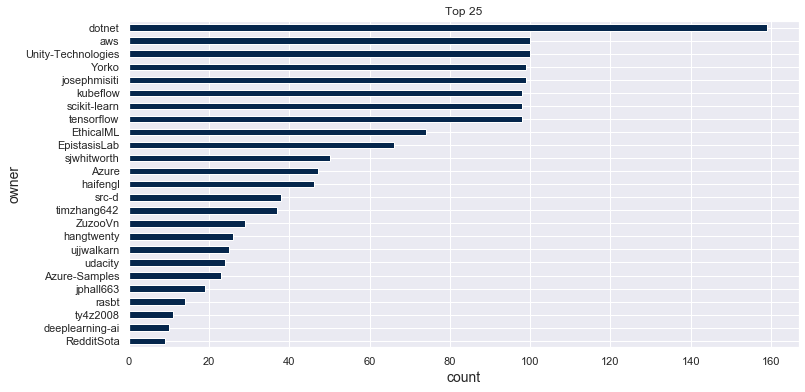

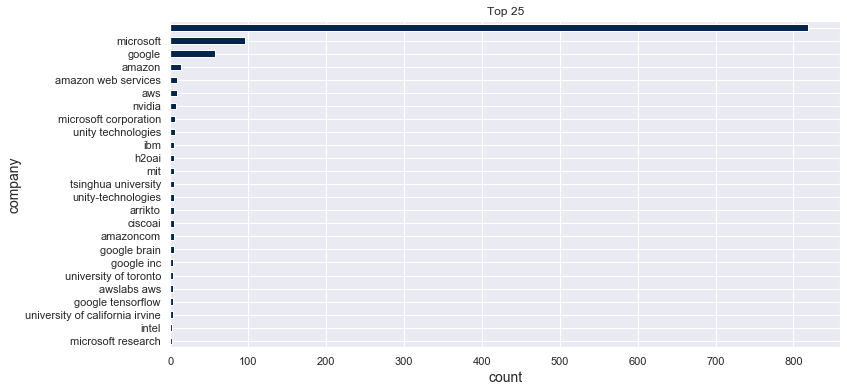

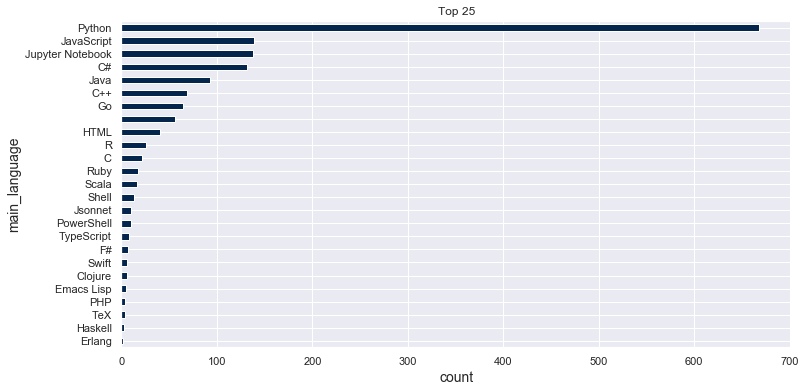

In [505]:
def bar_charts(df,cols):
    for col in cols:
        df[col].value_counts()[:25].plot.barh(color=blue[4], figsize=(12,6))
        plt.gca().invert_yaxis()
        plt.xlabel('count',fontsize=14)
        plt.ylabel(col,fontsize=14)
        plt.title('Top 25')
        plt.show()
        
bar_charts(df,['owner', 'company', 'main_language'])

### 2.2.2 Correlation

We investigate numeric variables against one another to reveal potential pairwise relationships in the data. We visualize the correlation using a scatter matrix and heat map.

In [459]:
corr = px.scatter_matrix(df, dimensions=numeric_cols, title='Correlation', height=750, width=850)
corr.show()

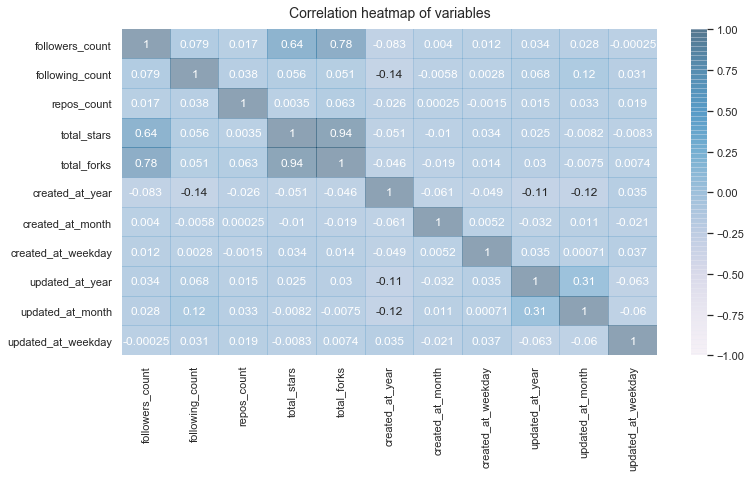

In [460]:
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='PuBu', alpha=0.4)
heatmap.set_title('Correlation heatmap of variables', fontsize=14, pad=12)
plt.show()

# 3 Tools, theory and analysis
*Structure:*
* Explain the overall idea
* Analysis step 1-n: explain what you're interested in, explain the tool, apply the tool, discuss the outcome

*Content:*
* Explain work with text, including regular expressions, unicode, etc.
* Describe network science tools and data analysis strategies used, how those network science measures work, and why the tools you've chosen are right for the problem
* How did you use the tools to understand your dataset?


In this section, we go deeper into the data and create our network of github users. First, we analyse the network according to network theory including ....... Next we analyse the individual users and finally make a cool visualisation. 
In the second part, we dig even deeper by detecting and exploring possible communities within the network. 


Step 1: Network analysis

Step 2: Spacio-temporal analysis

Step 2: Community analysis

## 3.1 Network analysis


explain what you're interested in

explain the tool

apply the tool

discuss the outcome


### 3.1.1 Network construction

The network of Github users is created using the Python package `networkx` for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. Since the users can either follow others or be followed by others, we generate a directed network using `DiGraph`. The users in the data are added as nodes and the users following each other get an edge between their nodes.

We make the assuption that important nodes or users have many connections. We extract the **weakly connected component**, which is the maximal subgraph of the directed graph such that for every pair of edges $u$, $v$ in the subgraph, there is an undirected path from $u$ to $v$ and a directed path from $v$ to $u$. This using `weakly_connected_components` which generates a sorted list of weakly connected components. Since we are interested in the largest one, we take the maximum of the weakly connected components. We then end up with the **giant connected component**, that contains a significant proportion of the entire nodes or users in the network. 

In [65]:
# create network
G = nx.DiGraph()

# add nodes as users
G.add_nodes_from(df['user_name'].values)

# add edges as users following each other 
for row in df.iterrows():
    z = [(row[1]['user_name'], other_node) for other_node in row[1]['following_relevant']]
    G.add_edges_from(z)
    
print(f"Number of nodes in total network: {G.number_of_nodes()}")
print(f"Number of edges in total network: {G.number_of_edges()}\n")
    
# extract giant connected component 
WCC = max(nx.weakly_connected_components(G), key=len)
GCC = G.subgraph(WCC)

print(f"Number of nodes in GCC: {GCC.number_of_nodes()}")
print(f"Number of edges in GCC: {GCC.number_of_edges()}")

Number of nodes in total network: 1585
Number of edges in total network: 2092

Number of nodes in GCC: 737
Number of edges in GCC: 2072


### 3.1.2 Centrality

The **degree centrality** is defined as the number of edges incident upon a node. Thus the degree can be interpreted as the risk of a node catching the information flowing through the network. In a directed network it makes sense to use **in- and out-degree** as measures of the degree centrality. 

We find the most central users according to in- and out-degree centrality.

In [80]:
df['in_degree'] = df['user_name'].apply(lambda x: G.in_degree(x))
print('Most central users according to in-degree')
display(df.sort_values(by=['in_degree'], ascending=False)[['user_name','name','in_degree']].head())

df['out_degree'] = df['user_name'].apply(lambda x: G.out_degree(x))
print('Most central users according to out-degree')
display(df.sort_values(by=['out_degree'], ascending=False)[['user_name','name','out_degree']].head())

df['degree'] = df['user_name'].apply(lambda x: G.degree(x))
print('Most central users according to in and out-degree')
display(df.sort_values(by=['degree'], ascending=False)[['user_name','name','degree']].head())

Most central users according to in-degree


user_name               name  in_degree
367    amueller    Andreas Mueller         67
417     ogrisel     Olivier Grisel         63
574    fchollet   François Chollet         58
26   llSourcell        Siraj Raval         56
3         rasbt  Sebastian Raschka         55

Most central users according to out-degree


user_name           name  out_degree
1178          yupbank        Peng Yu          68
575          feihugis         Fei Hu          43
1124        gaocegege         Ce Gao          42
1320  silverstone1903                         41
1042     justinormont  Justin Ormont          36

Most central users according to in and out-degree


user_name               name  degree
367   amueller    Andreas Mueller      83
417    ogrisel     Olivier Grisel      82
1178   yupbank            Peng Yu      72
155    soumith   Soumith Chintala      64
3        rasbt  Sebastian Raschka      60

Another centrality measure is the **eigenvector centrality**, which empathizes the influence of a node in the network. It assigns relative scores to all the nodes based on the assumption that connections to high-scoring nodes contribute more to the score than connections to low-scoring nodes. Again, we differentiate between edges going in- and out from the nodes.

In [89]:
in_eigen = nx.eigenvector_centrality(G)
out_eigen = nx.eigenvector_centrality(G.reverse())

print('Most central users according to in-degree eigenvector centrality')
display(collections.Counter(eigen_in).most_common(5))

print('Most central users according to out-degree eigenvector centrality')
display(collections.Counter(eigen_out).most_common(5))

Most central users according to in-degree eigenvector centrality


[('ogrisel', 0.4405505647025183),
 ('agramfort', 0.34844110020597974),
 ('mblondel', 0.3040223467028383),
 ('pprett', 0.26982207443164374),
 ('vene', 0.23751061433789955)]

Most central users according to out-degree eigenvector centrality


[('yupbank', 0.26117678401028804),
 ('silverstone1903', 0.25921019946051127),
 ('apachaves', 0.21937613674169368),
 ('agramfort', 0.2141773914930188),
 ('glemaitre', 0.18878915185637504)]

The **betweenness centrality** is another centrality measure. The algorithm chooses two random nodes, calculates the shortest path and give the nodes with high probability to occur on this path high centrality. Thus these the users with high betweenness centrality will often act as a bridges in the network between randomly chosen users.

In [135]:
bet_cent = nx.betweenness_centrality(GCC)
print('Most central users according to betweenness centrality')
display(collections.Counter(bet_cent).most_common(5))

Most central users according to betweenness centrality


[('terrytangyuan', 0.09648487859801515),
 ('gaocegege', 0.07463776920774011),
 ('rhiever', 0.04941400630930169),
 ('yupbank', 0.03785999702955615),
 ('agramfort', 0.032996435776303776)]

We see that the users ogrisel and silverstone1903, are central according to both degree- and eigenvector centrality. Further, the users agramfort and yupfort is has a lot of influence both when it comes to in and out-degree eigenvector centrality and betweenness centrality.

### 3.1.3 Degree distribution
We analyse how the node's degrees are distributed both for the total network and the GCC.  

In [136]:
def degree_distribution(G, mode):
    
    # find in or out degrees of network
    if mode.lower() == 'in':
        degree_sequence = [d for n, d in G.in_degree()]
    else:
        degree_sequence = [d for n, d in G.out_degree()]
    # find min and max of degrees     
    dmax = max(degree_sequence)
    dmin = min(degree_sequence)
    
    # compute frequencies of degrees distribution
    counts, bins = np.histogram(degree_sequence, bins = np.arange(dmin-0.5, dmax+1.5,1))
    
    # set style, figure size and title
    sns.set()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,4])
    fig.suptitle(mode+'-degree distribution',fontsize=16)
    
    # plot histogram 
    ax1.bar(np.arange(dmin, dmax+1,1), counts, color=blue[4], alpha=0.8)
    ax1.set_xlim(-0.5, dmax-20)
    ax1.set_ylim(-0.5, max(counts)+10)
    ax1.set_xlabel('node degree',fontsize=14)
    ax1.set_ylabel('count',fontsize=14)
    
    # plot scatter plot on log-log scale
    ax2.loglog(np.arange(dmin, dmax+1,1), counts, 'o', color=blue[2], alpha=0.9)
    ax2.set_xlim(0.5, 10**3)
    ax2.set_ylim(0.5, 10**3)
    ax2.set_xlabel('log(node degree)',fontsize=14)
    ax2.set_ylabel('log(count)',fontsize=14)
    plt.show()

Total network


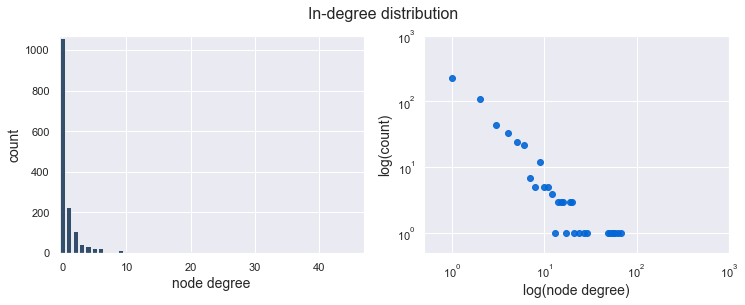

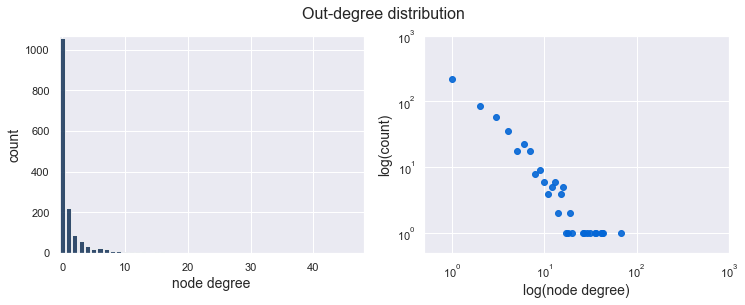

GCC


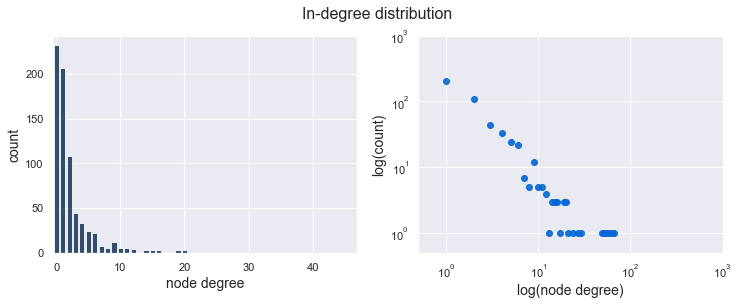

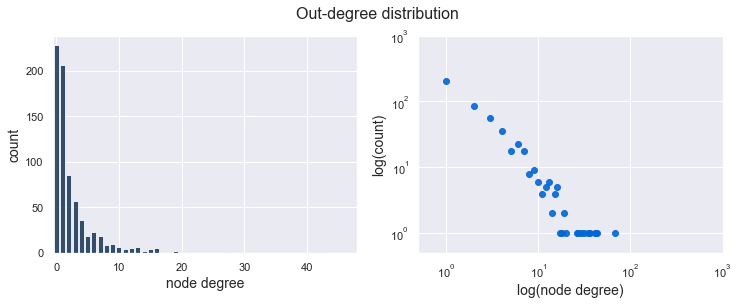

In [137]:
print('Total network')
degree_distribution(G,'In')
degree_distribution(G,'Out')

print('GCC')
degree_distribution(GCC,'In')
degree_distribution(GCC,'Out')

Both the total network and the GCC follow a power-law degree distribution which is typical for many scale-free, real world networks.

Correlation coefficient: 0.25


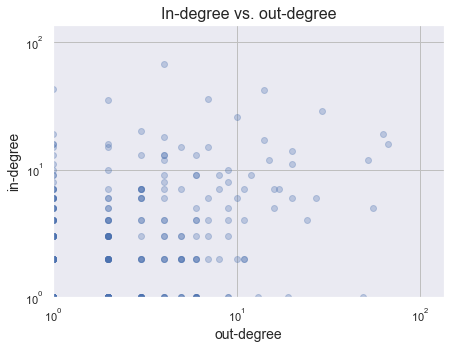

In [141]:
in_degree = [d for n, d in G.in_degree()]
out_degree = [d for n, d in G.out_degree()]
corr = np.corrcoef(x=out_degree, y=in_degree)[0, 1]
print('Correlation coefficient: {0}'.format(np.round(corr,2)))

sns.set()
fig, ax = plt.subplots(figsize = [7,5])
ax.set_title("In-degree vs. out-degree", fontsize=16)
ax.set_xlabel("out-degree",fontsize=14)
ax.set_ylabel("in-degree",fontsize=14)
ax.grid(True, linestyle='-', color='0.75')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1, max(in_degree) * 2])
ax.set_ylim([1, max(out_degree) * 2])
plt.scatter(in_degree, out_degree, alpha=0.3)
plt.show()

Since we found the network to have a power-law degree distribution, we further explore the [Friendship paradox](https://en.wikipedia.org/wiki/Friendship_paradox), which states that _almost everyone_ have fewer friends than their friends have, on average. We repeat the following three steps 1000 times to find out how many times the friendship paradox is true.

* Pick a node _i_ at random and find its degree
* Find _i_'s neighbors and calculate their average degree 
* Compare the two numbers to check if it's true that _i_'s friends (on average) have more friends than _i_.



In [142]:
def friendship_paradox(G):

    nodes = [n for n in G.nodes]
    iterations = 1000
    fp = np.zeros(iterations)

    for idx, it in enumerate(fp):
        node_i = random.choice(nodes) # pick random node
        k_i = G.degree(node_i) # find degree
        neigh_i = [n for n in G.neighbors(node_i)] # find degree of each neighbor
        neigh_avg_k = np.mean([G.degree(i) for i in neigh_i]) # find average degree of neighbors

        fp[idx] = neigh_avg_k > k_i # compare numbers 

    print('friendship paradox is true {} out of 1000 times'.format(sum(fp)))

In [143]:
print('Total network:')
friendship_paradox(G)
print('GGC:')
friendship_paradox(GCC)

Total network:
friendship paradox is true 271.0 out of 1000 times
GGC:
friendship paradox is true 574.0 out of 1000 times


### 3.1.4 Visualisation


Force2atlas algorithm

networkx draw

plotly graph

In [542]:
# convert to undirected graph while plotting
giant = GCC.to_undirected()

# scale node-size according to degree
d = dict(giant.degree)
sizes = [v * 10 for v in d.values()]

# settings for the Force Atlas 2 algorithm
forceatlas2 = ForceAtlas2(# behavior alternatives
                          outboundAttractionDistribution=False,  
                          # dissuade hubs
                          edgeWeightInfluence=0.5,
                          # performance
                          jitterTolerance=0.2, # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.6,
                          # tuning
                          scalingRatio=5.0,
                          strongGravityMode=True,
                          gravity=1,
                          # log
                          verbose=True)

# get positions based on theForce Atlas 2 algorithm
positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)



  0%|          | 0/2000 [00:00<?, ?it/s]

  1%|          | 14/2000 [00:00<00:15, 130.18it/s]

  1%|▏         | 27/2000 [00:00<00:15, 129.17it/s]

  2%|▏         | 41/2000 [00:00<00:15, 129.87it/s]

  3%|▎         | 55/2000 [00:00<00:14, 132.05it/s]

  3%|▎         | 69/2000 [00:00<00:14, 131.74it/s]

  4%|▍         | 83/2000 [00:00<00:14, 133.58it/s]

  5%|▍         | 97/2000 [00:00<00:14, 134.83it/s]

  6%|▌         | 111/2000 [00:00<00:14, 134.53it/s]

  6%|▋         | 125/2000 [00:00<00:14, 133.39it/s]

  7%|▋         | 138/2000 [00:01<00:14, 132.21it/s]

  8%|▊         | 152/2000 [00:01<00:13, 133.99it/s]

  8%|▊         | 166/2000 [00:01<00:13, 132.44it/s]

  9%|▉         | 180/2000 [00:01<00:13, 131.04it/s]

 10%|▉         | 193/2000 [00:01<00:13, 130.11it/s]

 10%|█         | 206/2000 [00:01<00:13, 128.87it/s]

 11%|█         | 219/2000 [00:01<00:13, 128.66it/s]

 12%|█▏        | 232/2000 [00:01<00:13, 126.47it/s]

 12%|█▏        | 246/2000 [00:01<00:13, 128.14it/s]

 13%|█▎  

 94%|█████████▎| 1872/2000 [00:15<00:00, 134.27it/s]

 94%|█████████▍| 1886/2000 [00:15<00:00, 135.40it/s]

 95%|█████████▌| 1900/2000 [00:15<00:00, 134.46it/s]

 96%|█████████▌| 1914/2000 [00:15<00:00, 132.54it/s]

 96%|█████████▋| 1928/2000 [00:16<00:00, 130.99it/s]

 97%|█████████▋| 1942/2000 [00:16<00:00, 131.53it/s]

 98%|█████████▊| 1956/2000 [00:16<00:00, 131.54it/s]

 98%|█████████▊| 1970/2000 [00:16<00:00, 132.26it/s]

 99%|█████████▉| 1984/2000 [00:16<00:00, 133.23it/s]

100%|██████████| 2000/2000 [00:16<00:00, 120.79it/s]

BarnesHut Approximation  took  2.48  seconds
Repulsion forces  took  13.16  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.26  seconds


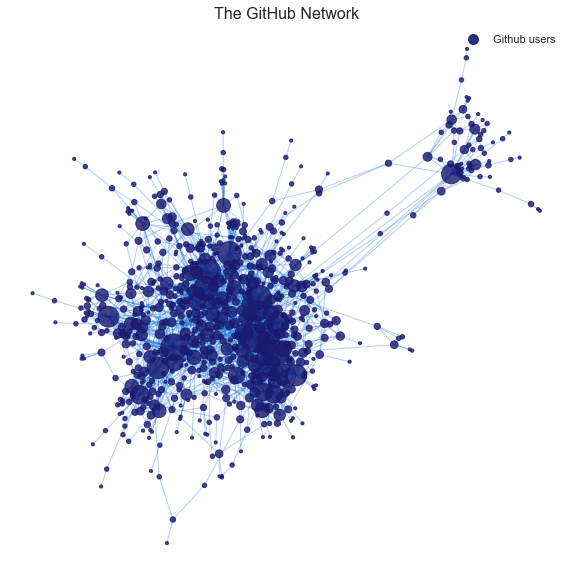

In [544]:
# set style, figure size and title
sns.set()
fig = plt.figure(figsize=(10,10))
plt.title('The GitHub Network', fontsize=16)

# draw network
nx.draw_networkx_nodes(giant, positions, node_color=blue[5], alpha=0.8, node_size=sizes)
nx.draw_networkx_edges(giant, positions, edge_color=blue[2], alpha=0.3)
 
# create legend and remove axes 
plt.scatter([], [], c=blue[5], alpha=0.9, s=100, label='Github users')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
plt.axis('off')
plt.show()

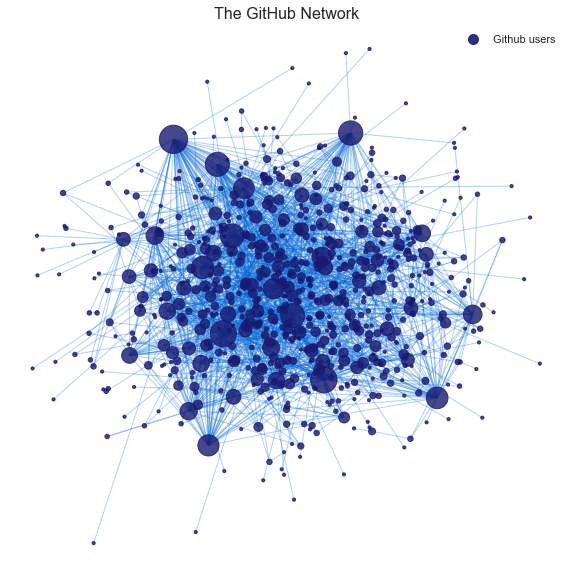

In [155]:
# set style, figure size and title
sns.set()
fig = plt.figure(figsize=(10,10))
plt.title('The GitHub Network', fontsize=16)

# draw network
nx.draw_networkx_nodes(giant, positions, node_color=blue[5], alpha=0.8, node_size=sizes)
nx.draw_networkx_edges(giant, positions, edge_color=blue[2], alpha=0.3)
 
# create legend and remove axes 
plt.scatter([], [], c=blue[5], alpha=0.9, s=100, label='Github users')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
plt.axis('off')

plt.show()
#fig.savefig('network.png', facecolor=fig.get_facecolor(), transparent=True)

In [545]:
def make_edge(x, y, text, geo):

    if geo == True:
        fig = go.Scattergeo(lon=y,
                            lat=x,
                            line=dict(width=0.2,
                                      color=blue[2]),

                            hoverinfo='text',
                            text=([text]),
                            mode='lines')

    else:
        fig = go.Scatter(x=x,
                         y=y,
                         line=dict(width=0.5,
                                   color=blue[2]),

                         hoverinfo='text',
                         text=([text]),
                         mode='lines')
    return fig


def plotly_graph(graph, pos_list, title, geo):

    midsummer = graph
    pos = pos_list

    # make edge trace
    edge_trace = []
    for edge in midsummer.edges():

        char_1 = edge[0]
        char_2 = edge[1]

        if geo == True:
            x0, y0 = midsummer.nodes[char_1]['pos']
            x1, y1 = midsummer.nodes[char_2]['pos']

        else:
            x0, y0 = pos[char_1]
            x1, y1 = pos[char_2]

        text = char_1 + '--' + char_2
        trace = make_edge([x0, x1, None], [y0, y1, None], text, geo)

        edge_trace.append(trace)

    # Make a node trace
    if geo == True:
        node_trace = go.Scattergeo(lon=[],
                                   lat=[],
                                   text=[],
                                   textposition="top center",
                                   textfont_size=1,
                                   mode='markers+text',
                                   hoverinfo='text',
                                   marker=dict(color=[],
                                                size=[],
                                                line=None))
    else:
        node_trace = go.Scatter(x=[],
                                y=[],
                                text=[],
                                textposition="top center",
                                textfont_size=1,
                                mode='markers+text',
                                hoverinfo='text',
                                marker=dict(color=[],
                                             size=[],
                                             line=None))

    # For each node in midsummer, get the position and size and add to the node_trace
    for node in midsummer.nodes():
        if geo == True:
            lat, lon = midsummer.nodes[node]['pos']
            node_trace['lat'] += tuple([lat])
            node_trace['lon'] += tuple([lon])
            deg = dict(midsummer.degree)[node]
            if deg < 5:
                deg = 5
            else:
                deg = deg/2

            node_trace['marker']['size'] += tuple([deg])

        else:
            x, y = pos[node]
            node_trace['x'] += tuple([x])
            node_trace['y'] += tuple([y])
            node_trace['marker']['color'] += tuple([blue[5]])

            deg = dict(midsummer.degree)[node]
            if deg < 5:
                deg = 5

            node_trace['marker']['size'] += tuple([deg])

        node_trace['text'] += tuple(['<b>' + node + '</b>'])

    # Customize layout
    layout = go.Layout(
        paper_bgcolor='rgba(0,0,0,0)',  # transparent background
        plot_bgcolor='rgba(0,0,0,0)',  # transparent 2nd background
        xaxis={'showgrid': False, 'zeroline': False},  # no gridlines
        yaxis={'showgrid': False, 'zeroline': False},  # no gridlines
    )
    # Create figure
    fig = go.Figure(layout=layout)
    # Add all edge traces
    for trace in edge_trace:
        fig.add_trace(trace)
    # Add node trace
    fig.add_trace(node_trace)
    # Remove legend
    fig.update_layout(showlegend=False)
    fig.update_layout(title_text=title)
    # Remove tick labels
    trace1 = fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(height=500, margin={"r": 0, "t": 0, "l": 0, "b": 0})

    # Show figure
    return fig

fig = plotly_graph(giant, positions, 'Giant connected component', False)
fig
# fig.write_html("data/gcc.html")

### 3.1.5 Text analysis

In [201]:
mis = []
def tokenize(df,col):
    df[f'Tokens_{col}'] = ""
    for i,content in enumerate(df[col]):
        try:
            text = content.translate(str.maketrans('', '', string.punctuation)).split() # split to tokens
            sw = stopwords.words("english") # set stopwords
            wordnet_lemmatizer = WordNetLemmatizer() # set lemmatizer
            words1= [t.lower() for t in text] # lower letters
            words11 = [t for t in words1 if t not in sw]   # remove stopwords
            words2 = [wordnet_lemmatizer.lemmatize(t) for t in words11]  # lemmatize
            words3 = [x for x in words2 if not any(c.isdigit() for c in x)] # remove words with numbers
            df[f'Tokens_{col}'][i] = words3
        except:
            mis.append(i)
  
tokenize(df,'description')
tokenize(df,'bio')
df['Tokens_used_languages'] = df['used_languages']

In [202]:
def get_TF(df,col):
    words = []
    for x in df[f'Tokens_{col}']:
        words.extend(x)

    TF = FreqDist(words)

    return TF, words

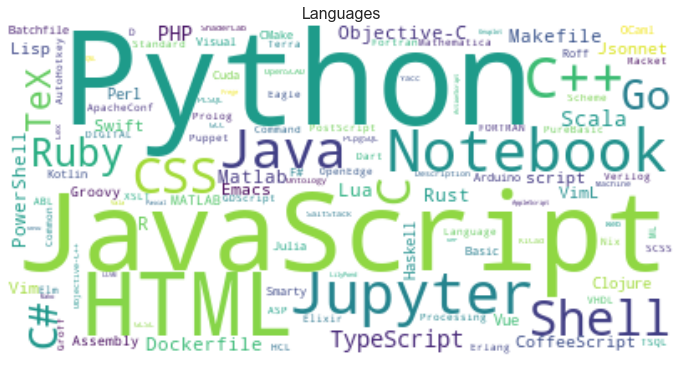

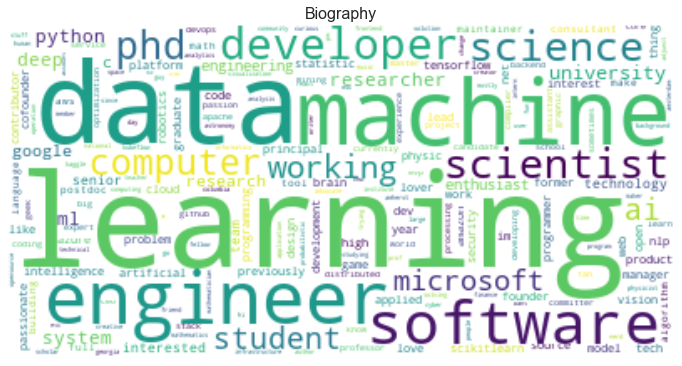

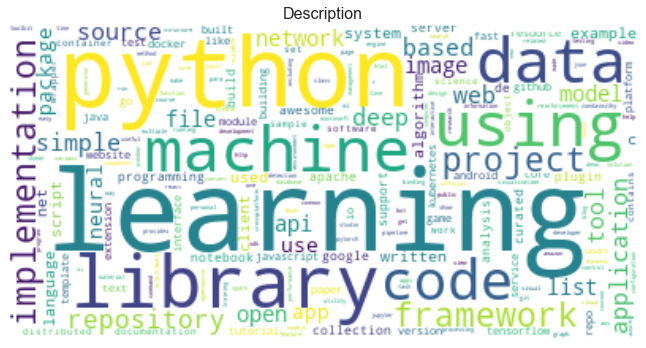

In [165]:
TFF = get_TF(df,'used_languages')[0]

# create WordCloud
wordcloud = WordCloud(background_color='white', collocations = False).generate_from_frequencies(TFF)

# plot the WordCloud image         
plt.figure(figsize=(10, 5), facecolor = None)
img = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.title('Languages',fontsize=16)

TFF = get_TF(df,'bio')[0]

# create WordCloud
wordcloud = WordCloud(background_color='white', collocations = False).generate_from_frequencies(TFF)

# plot the WordCloud image         
plt.figure(figsize=(10, 5), facecolor = None)
img = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.title('Biography',fontsize=16)

TFF = get_TF(df,'description')[0]

# create WordCloud
wordcloud = WordCloud(background_color='white', collocations = False).generate_from_frequencies(TFF)

# plot the WordCloud image         
plt.figure(figsize=(10, 5), facecolor = None)
img = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Description',fontsize=16)

plt.tight_layout()
plt.show()

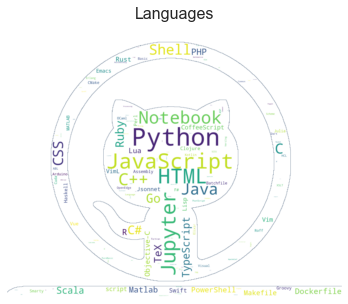

In [235]:
# get shape from image
mask = np.array(Image.open(r"data/github.png"))

# create WordCloud
TFF = get_TF(df,'used_languages')[0]
wordcloud = WordCloud(background_color='white', mask=mask, contour_width = 0.5, contour_color = blue[4], collocations = False).generate_from_frequencies(TFF)

# plot the WordCloud image         
plt.figure(figsize=(10, 5), facecolor = None)
img = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Languages',fontsize=16)
plt.show()

### 3.1.6 User analysis

 4. What users are worth following?
    - Based on followers, stars, forks, repositories, activity and topics
    - Based on sentiment

In [236]:
top_followers = df.sort_values(by='followers_count', axis=0, ascending=False)
fig = px.bar(top_followers[:100], x='user_name', y='followers_count', hover_data=['followers_count'])
fig.update_layout(height=450, width=750, title_text='The most popular users')
fig.show()

In [237]:
top_following = df.sort_values(by='following_count', axis=0, ascending=False)
fig = px.bar(top_following[:100], x='user_name', y='following_count', hover_data=['following_count'])
fig.update_layout(height=450, width=750, title_text='Fan users following other users the most')
fig.show()

In [238]:
# determine what percentage of followers top 1% of users get
top = int(len(top_followers) * 0.01)
perc = sum(top_followers.iloc[0: top,:].loc[:, 'followers_count'])/sum(top_followers.followers_count)*100
print(f'1 % of the top users have {round(perc,1)} % of the followers')

1 % of the top users have 31.7 % of the followers


In [239]:
top_followers = df.sort_values(by='followers_count', axis=0, ascending=False)
fig = px.bar(top_followers[:100], x='user_name', y='followers_count', hover_data=['followers_count'])
fig.update_layout(height=450, width=750, title_text='The most popular users')
fig.show()

In [240]:
top_stars = df.sort_values(by='total_stars', axis=0, ascending=False)
fig = px.bar(top_stars[:100], x='user_name', y='total_stars', hover_data=['total_stars'])
fig.update_layout(height=450, width=750, title_text='Users with the most stars')
fig.show()

In [241]:
top_forks = df.sort_values(by='total_forks', axis=0, ascending=False)
fig = px.bar(top_forks[:100], x='user_name', y='total_forks', hover_data=['total_forks'])
fig.update_layout(height=450, width=750, title_text='Users with the most forks')
fig.show()

In [242]:
top_repos = df.sort_values(by='repos_count', axis=0, ascending=False)
fig = px.bar(top_repos[:100], x='user_name', y='repos_count', hover_data=['repos_count'])
fig.update_layout(height=450, width=750, title_text='Users with the most repositories')
fig.show()

### 3.1.7 Sentiment analysis

In [243]:
word_df = pd.read_csv('data/happiness_text.txt',skiprows=2,sep='\t')
word_df.head()

word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332

In [244]:
def sentiment(tokens):
    # find words that are in the 'happiness list'
    sim_words = list(set(tokens) & set(word_df['word']))
    # frequency count
    fd = FreqDist([word for word in tokens if word in sim_words])
    sent = word_df[word_df['word'].isin(
        sim_words)][['word', 'happiness_average']]  # get happiness scores
    sent['freq'] = sent['word']
    sent = sent.replace({"freq": fd})
    final_sent = np.mean(sent['happiness_average']*sent['freq'])
    
    return final_sent

In [245]:
df['Sentiment_desc'] = ""
df['Sentiment_bio'] = ""

for i in range(len(df)):
    
    tokens1=df['Tokens_description'].iloc[i]
    tokens2=df['Tokens_bio'].iloc[i]
    
    df['Sentiment_desc'][i] = sentiment(tokens1)
    df['Sentiment_bio'][i] = sentiment(tokens2)
    
   
df.head()

user_name         owner                                    repos  \
0  josephmisiti  josephmisiti                 awesome-machine-learning   
1          wepe          wepe                          MachineLearning   
2       ZuzooVn       ZuzooVn  machine-learning-for-software-engineers   
3  Jack-Cherish  Jack-Cherish                         Machine-Learning   
4     lawlite19     lawlite19                   MachineLearning_Python   

            name                  company        location  \
0  Joseph Misiti            math & pencil     brooklyn ny   
1          wepon                   antfin  china hangzhou   
2         Nam Vu                                  vietnam   
3       Jack Cui  northeastern university           china   
4        lawlite     southeast university   nanjing china   

                                                 bio  \
0        Mathematician & Co-founder of Math & Pencil   
1                                                      
2  A Vietnamese Software Engineer who is really p...   
3                            :octocat:公众号：JackCui-AI   
4                                                      

                 created_at                updated_at  \
0 2010-04-17 21:09:13+00:00 2020-10-29 18:11:39+00:00   
1 2014-10-10 14:28:18+00:00 2020-11-05 15:54:10+00:00   
2 2012-02-11 16:55:02+00:00 2020-10-12 02:40:45+00:00   
3 2016-01-25 03:38:06+00:00 2020-07-31 13:54:15+00:00   
4 2015-09-19 02:51:34+00:00 2020-10-22 16:26:53+00:00   

                                           following  ...  \
0  [mojombo, defunkt, vanpelt, macournoyer, ry, b...  ...   
1  [pluskid, benanne, colah, kennethreitz42, karp...  ...   
2  [ole, escoz, pokeb, tcdoan, dyang, kirill-grou...  ...   
3  [kennethreitz42, karpathy, marvis, shicai, tia...  ...   
4  [lifesinger, sofish, sindresorhus, BYVoid, jav...  ...   

                 coordinates  \
0  (40.6501038, -73.9495823)   
1  (30.2489634, 120.2052342)   
2  (13.2904027, 108.4265113)   
3    (35.000074, 104.999927)   
4  (32.0609736, 118.7916458)   

                                             address   longitude   latitude  \
0  Brooklyn, Kings County, New York, United State...  -73.949582  40.650104   
1                            杭州市, 江干区, 浙江省, China 中国  120.205234  30.248963   
2                                           Việt Nam  108.426511  13.290403   
3                                                 中国  104.999927  35.000074   
4                            南京市, 盱眙县, 江苏省, China 中国  118.791646  32.060974   

                              following_relevant_loc  \
0  [JWarmenhoven, agramfort, alextp, amueller, ba...   
1                [aymericdamien, enjoyhot, guolinke]   
2                                          [jwasham]   
3                                                 []   
4                                             [wepe]   

                                  Tokens_description  \
0  [sdk, example, code, building, voiceenabled, s...   
1  [place, season, one, place, season, place, sol...   
2  [android, executables, browsereasy, use, cfnet...   
3                                                 []   
4  [算法练习oj平台算法java实现博客相关文件存储个人博客gitalk评论仓库使用scrap...   

                                          Tokens_bio  \
0           [mathematician, cofounder, math, pencil]   
1                                                 []   
2  [vietnamese, software, engineer, really, passi...   
3                             [octocat公众号：jackcuiai]   
4                                                 []   

                               Tokens_used_languages  Sentiment_desc  \
0  [C, C++, CSS, CoffeeScript, Go, HTML, Java, Ja...          11.111   
1                   [C++, HTML, Java, Python, Shell]         7.83353   
2  [C, DIGITAL, Command, Language, HTML, Java, Ja...          7.7785   
3                                [C++, HTML, Python]             NaN   
4  [C++, HTML, Java, JavaScript, Matlab, Python, ...            6.02   

  Sentiment_bio  
0          5.46  

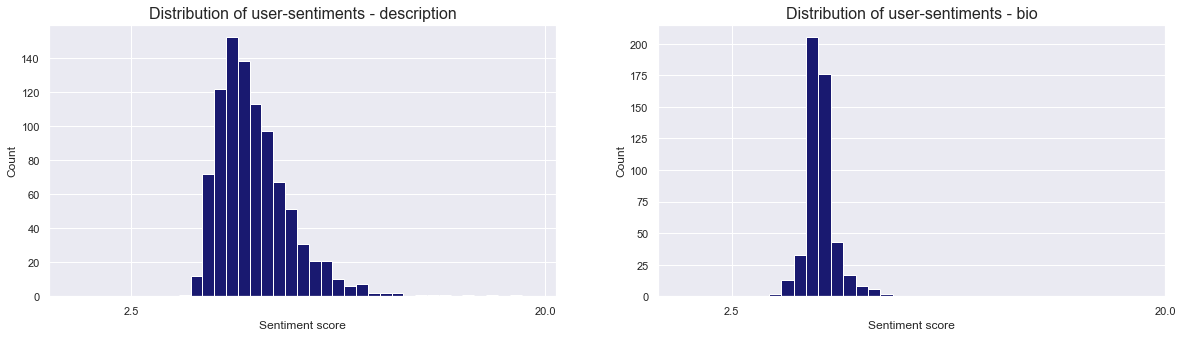

In [246]:
#distribution of user sentiments

sns.set()
plt.figure(figsize=(20, 5))

plt.subplot(121)
bins = [x*0.5 for x in list(range(40))]
plt.hist(df['Sentiment_desc'].dropna(), color='midnightblue',bins=bins)
plt.title('Distribution of user-sentiments - description', fontsize=16)
plt.xlabel('Sentiment score')
plt.ylabel('Count')
plt.xticks([2.5,20])

plt.subplot(122)
bins = [x*0.5 for x in list(range(20))]
plt.hist(df['Sentiment_bio'].dropna(), color='midnightblue',bins=bins)
plt.title('Distribution of user-sentiments - bio', fontsize=16)
plt.xlabel('Sentiment score')
plt.ylabel('Count')
plt.xticks([2.5,20])
plt.show()

In [247]:
def happy_sad(df,col,num,name):
    
    df_not = df[df[col].notna()].reset_index(drop=True)

    print('\nDESCRIPTIONS')
    top = np.argsort(df_not[col])[-num:]
    bot = np.argsort(df_not[col])[:num]
    
    top_df = df_not.iloc[top]
    bot_df = df_not.iloc[bot]

    print(f'Top {num} happiest')
    display(top_df[[name,col]][::-1].reset_index(drop=True))

    print(f'\nTop {num} saddest')
    display(bot_df[[name,col]][::-1].reset_index(drop=True))
    
    return top_df, bot_df

In [248]:
_,_ =happy_sad(df,'Sentiment_desc',10,'user_name')


DESCRIPTIONS
Top 10 happiest


user_name Sentiment_desc
0           bryant1410        37.0353
1              cclauss        29.5135
2                forki        18.7633
3          kastnerkyle        17.8092
4                   JJ        16.7028
5            ezefranca        15.6272
6           NMZivkovic        15.2596
7             willingc         14.987
8             sharwell        13.7118
9  markyjackson-taulia         13.508


Top 10 saddest


user_name Sentiment_desc
0         jsgv          5.445
1       Qovaxx        5.42143
2  fixingitnow        5.38545
3      Amphyby          5.368
4     adrag239           5.34
5    wenhan-wu          5.332
6    hbaniecki        5.28933
7     dmalpica        5.27857
8   chriselion        5.10364
9  thesimanjan           4.88

In [249]:
_,_ =happy_sad(df,'Sentiment_bio',10,'user_name')


DESCRIPTIONS
Top 10 happiest


user_name Sentiment_bio
0        automata         13.64
1    McCulloughRT         10.76
2    WillKoehrsen         10.68
3     ShengKungYi         8.885
4       wenhan-wu          8.51
5      Nativeatom         8.495
6          channy         8.495
7           bamos          8.47
8         xadupre       8.33143
9  kailashahirwar          8.32


Top 10 saddest


user_name Sentiment_bio
0               c-bata          4.92
1            linkerlin           4.9
2          AnshulBasia         4.876
3               chkoar       4.80667
4  snowflowersnowflake       4.76667
5               ljpzzz          4.72
6            la-cruche           4.6
7                optas          4.52
8        strange-jiong          4.46
9            dangsonbk         4.285

## 3.2 Spacio-temporal analysis

### 3.2.1 Development
We start by exploring the network accross time in order to reveal any development trends for GitHub.

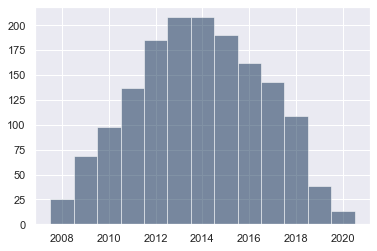

In [444]:
years_count = np.unique(df['created_at_year'],return_counts=True)
years = years_count[0]
bins = [y-0.5 for y in list(years)+[2021]]
plt.hist(df['created_at_year'],bins=bins,color=blue[4],alpha=0.5)
plt.show()

In [251]:
year_com = [years[0:i] for i in range(1,len(years)+1)]

def get_year(year_range):   

    df_year = df[df['created_at_year'].isin(year_range)]
    G = nx.DiGraph()
    G.add_nodes_from(df_year['user_name'].values)

    for row in df_year.iterrows():
        z = [(row[1]['user_name'], other_node) for other_node in row[1]['following_relevant']]
        G.add_edges_from(z)

    # extract giant connected component 
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    GCC = G.subgraph(largest_cc)
    giant = GCC.to_undirected()

    return df_year, giant


In [252]:
def year_detail(year_range):
    giant2 = get_year(year_range)[1]
    positions = forceatlas2.forceatlas2_networkx_layout(giant2, pos=None, iterations=10)  
    
    d = dict(giant2.degree)
    sizes = [v *10 for v in d.values()]
    
    return giant2, positions,sizes

In [253]:
df_year = pd.DataFrame()
df_year['Years'] = years 

names = []
names2 = []
for y in years:
    com_df = get_year([y])[0].reset_index(drop=True)
    
    langs = np.unique(list(com_df['main_language']),return_counts=True)[0]
    c_langs = np.unique(list(com_df['main_language']),return_counts=True)[1]
    name = langs[np.argsort(c_langs)[-3:]]
  
    names.append('-'.join(name)) # name communities    
    
    top3 = list(np.argsort(com_df['degree'])[-3:]) # get top three most connected characters
    name2 = [com_df['user_name'][idx] for idx in top3][::-1]
    connects = [com_df['degree'][idx] for idx in top3][::-1]
    
  
    names2.append('-'.join(name2))
      
df_year['Top_languages'] = names
df_year['Top_usernames'] = names2
df_year

KeyError: 'degree'

In [ ]:
graphs_year= []
positions_year = []
sizes_year =[]

for y in year_com:    
    g1 = year_detail(y)[0]
    pos1 = year_detail(y)[1]
    size1 =  year_detail(y)[2]
  
    graphs_year.append(g1)
    positions_year.append(pos1)
    sizes_year.append(size1)

for i in range(len(years)):
    fig_y = plotly_graph(graphs_year[i],positions_year[i])
    fig_y.write_html(f"data/year{i}.html")


In [ ]:
# set style, figure size and title
sns.set()
plt.figure(figsize=(40,40))

for i in range(len(year_com)):
    
    comnum=i
    
    plt.subplot(4,5,i+1)

    # draw network
    nx.draw_networkx_nodes(graphs_list[comnum], positions_list[comnum], node_color=blue[5], alpha=0.8, node_size=sizes_list[comnum])
    nx.draw_networkx_edges(graphs_list[comnum], positions_list[comnum], edge_color=blue[2], alpha=0.3)
   # plt.scatter([], [], c=blue[5], alpha=0.9, s=100, label='Github users')
    
   # plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
    plt.axis('off')
    #plt.title(f'Community {top[i]}')

plt.show()

In [ ]:
sns.set()
plt.figure(figsize=(20,40))
# create subplots
for i in range(len(years)):
    plt.subplot(8,2,(i*2)+1)
    create_wordcloud(i,'used_languages','years') 
    plt.axis("off")
    #plt.title(f'Community {top[i]}')
    plt.subplot(8,2,(i*2)+2)   
    create_wordcloud(i,'bio','years')
   # plt.title(f'Community {top[i]}')
 
plt.tight_layout()
plt.show()

### 3.2.2 Locations

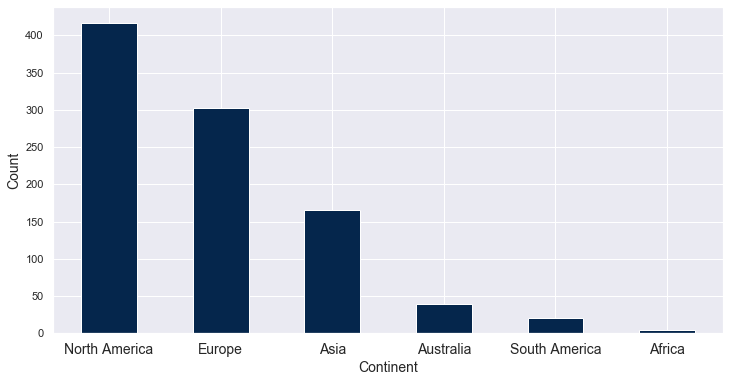

In [514]:
location_df['continent'].value_counts().plot.bar(color=blue[4], figsize=(12,6))
plt.xlabel('Continent',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.show()

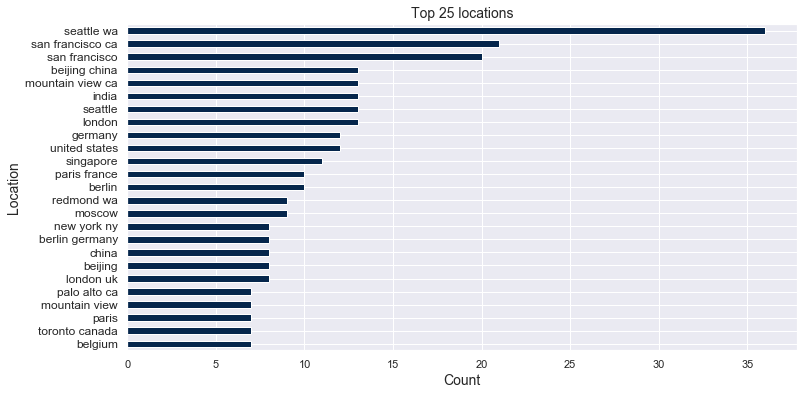

In [515]:
location_df['location'].value_counts()[:25].plot.barh(color=blue[4], figsize=(12,6))
plt.ylabel('Location',fontsize=14)
plt.xlabel('Count',fontsize=14)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()
plt.title('Top 25 locations',fontsize=14)
plt.show()

We visualize the location of the different users with `plotly`'s `scatter_geo` map. The size of the nodes depend on the `followers_count` and the color depend on `total_stars` the user has on its repos.  

In [516]:
m = px.scatter_geo(location_df, lat='latitude', lon='longitude',
                   color='total_stars', size='followers_count',
                   hover_data=['user_name','followers_count'],
                   title='Locations of top users',
                   width=800, height=500)
m.show()

We also visualize the locations using an interactive `folium` map with location marker clusters. 

In [547]:
# base map
m = folium.Map(tiles=None)

# add tile layers to the map
folium.TileLayer('cartodbpositron', show=True, name="light").add_to(m)
folium.TileLayer('cartodbdark_matter', show=False, name="dark").add_to(m)
folium.TileLayer('openstreetmap', show=False, name="color").add_to(m)

# add location marker clusters
mc = MarkerCluster(name='User locations')
df = location_df.dropna(subset=['latitude','longitude']).reset_index(drop=True)
sw = location_df[['latitude','longitude']].min().values.tolist()
ne = location_df[['latitude','longitude']].max().values.tolist()
m.fit_bounds([sw, ne]) 

# create marker at locations
for lat, lon, location, user_name, followers, following, stars in zip(location_df['latitude'], location_df['longitude'], location_df['location'], location_df['user_name'],
                                                                      location_df['followers_count'], location_df['following_count'], location_df['total_stars']):
    text = folium.Html('User name: {}<br> Location: {}<br> Followers: {}<br> Following: {}<br> Stars: {}<br>'.format(user_name, location, followers, following, stars), script=True)
    popup = folium.Popup(text, max_width=300)
    folium.CircleMarker(location=[lat, lon], 
                        radius=2,
                        weight=5,
                        color='#081d58', 
                        fill_color='#081d58', 
                        fill = True,
                        popup=popup,
                        tooltip='Click on GitHub user'
                        ).add_to(mc)
mc.add_to(m)

# add layer control
folium.LayerControl('topright', collapsed=False).add_to(m) 
m
#m.save('folium_map.html')

In [550]:
# get positions based on theForce Atlas 2 algorithm
positions = forceatlas2.forceatlas2_networkx_layout(location_G, pos=None, iterations=2000)

# get positions based on theForce Atlas 2 algorithm
positions = forceatlas2.forceatlas2_networkx_layout(location_G, pos=None, iterations=2000)
#positions = nx.get_node_attributes(location_G, 'pos')
#positions = nx.spring_layout(G)



  0%|          | 0/2000 [00:00<?, ?it/s]

  1%|          | 11/2000 [00:00<00:19, 102.31it/s]

  1%|          | 22/2000 [00:00<00:19, 102.04it/s]

  2%|▏         | 30/2000 [00:00<00:21, 91.22it/s] 

  2%|▏         | 41/2000 [00:00<00:20, 95.35it/s]

  3%|▎         | 52/2000 [00:00<00:19, 97.55it/s]

  3%|▎         | 63/2000 [00:00<00:19, 98.95it/s]

  4%|▎         | 74/2000 [00:00<00:19, 100.55it/s]

  4%|▍         | 84/2000 [00:00<00:19, 100.29it/s]

  5%|▍         | 95/2000 [00:00<00:18, 100.70it/s]

  5%|▌         | 106/2000 [00:01<00:18, 100.99it/s]

  6%|▌         | 117/2000 [00:01<00:18, 101.68it/s]

  6%|▋         | 128/2000 [00:01<00:18, 101.43it/s]

  7%|▋         | 139/2000 [00:01<00:18, 98.02it/s] 

  7%|▋         | 149/2000 [00:01<00:18, 97.65it/s]

  8%|▊         | 159/2000 [00:01<00:19, 96.06it/s]

  8%|▊         | 169/2000 [00:02<00:42, 43.06it/s]

  9%|▉         | 180/2000 [00:02<00:34, 52.10it/s]

 10%|▉         | 191/2000 [00:02<00:29, 60.98it/s]

 10%|█         | 20

 71%|███████   | 1422/2000 [00:16<00:06, 93.33it/s]

 72%|███████▏  | 1432/2000 [00:16<00:06, 93.31it/s]

 72%|███████▏  | 1442/2000 [00:16<00:06, 92.93it/s]

 73%|███████▎  | 1452/2000 [00:16<00:05, 93.10it/s]

 73%|███████▎  | 1462/2000 [00:16<00:12, 43.95it/s]

 74%|███████▎  | 1472/2000 [00:17<00:10, 52.12it/s]

 74%|███████▍  | 1482/2000 [00:17<00:08, 60.30it/s]

 75%|███████▍  | 1491/2000 [00:17<00:07, 66.35it/s]

 75%|███████▌  | 1501/2000 [00:17<00:06, 73.09it/s]

 76%|███████▌  | 1511/2000 [00:17<00:06, 78.14it/s]

 76%|███████▌  | 1521/2000 [00:17<00:05, 81.99it/s]

 77%|███████▋  | 1531/2000 [00:17<00:05, 85.85it/s]

 77%|███████▋  | 1541/2000 [00:17<00:05, 88.45it/s]

 78%|███████▊  | 1551/2000 [00:17<00:04, 90.41it/s]

 78%|███████▊  | 1561/2000 [00:18<00:04, 91.71it/s]

 79%|███████▊  | 1571/2000 [00:18<00:04, 92.64it/s]

 79%|███████▉  | 1581/2000 [00:18<00:04, 92.88it/s]

 80%|███████▉  | 1591/2000 [00:18<00:04, 92.78it/s]

 80%|████████  | 1601/2000 [00:18<00:04, 92.08

BarnesHut Approximation  took  4.41  seconds
Repulsion forces  took  17.85  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.36  seconds




  1%|          | 22/2000 [00:00<00:18, 104.25it/s]

  2%|▏         | 33/2000 [00:00<00:18, 103.53it/s]

  2%|▏         | 44/2000 [00:00<00:18, 103.31it/s]

  3%|▎         | 54/2000 [00:00<00:19, 101.90it/s]

  3%|▎         | 65/2000 [00:00<00:19, 101.48it/s]

  4%|▍         | 75/2000 [00:00<00:19, 99.58it/s] 

  4%|▍         | 85/2000 [00:00<00:19, 99.43it/s]

  5%|▍         | 95/2000 [00:00<00:19, 99.59it/s]

  5%|▌         | 106/2000 [00:01<00:18, 100.22it/s]

  6%|▌         | 116/2000 [00:01<00:18, 99.94it/s] 

  6%|▋         | 126/2000 [00:01<00:41, 44.64it/s]

  7%|▋         | 135/2000 [00:01<00:35, 52.30it/s]

  7%|▋         | 145/2000 [00:01<00:30, 60.46it/s]

  8%|▊         | 155/2000 [00:01<00:27, 67.69it/s]

  8%|▊         | 165/2000 [00:02<00:24, 73.96it/s]

  9%|▉         | 175/2000 [00:02<00:23, 79.05it/s]

  9%|▉         | 185/2000 [00:02<00:21, 82.71it/s]

 10%|▉         | 195/2000 [00:02<00:21, 85.86it/s]

 10%|█         | 205/2000 [00:02<00:20, 88.83it/s]

 11%|█    

 69%|██████▉   | 1389/2000 [00:16<00:06, 87.59it/s]

 70%|██████▉   | 1398/2000 [00:16<00:06, 87.62it/s]

 70%|███████   | 1407/2000 [00:17<00:06, 87.97it/s]

 71%|███████   | 1416/2000 [00:17<00:06, 87.33it/s]

 71%|███████▏  | 1425/2000 [00:17<00:06, 87.51it/s]

 72%|███████▏  | 1434/2000 [00:17<00:06, 87.95it/s]

 72%|███████▏  | 1444/2000 [00:17<00:06, 88.73it/s]

 73%|███████▎  | 1453/2000 [00:17<00:06, 88.09it/s]

 73%|███████▎  | 1463/2000 [00:17<00:06, 88.70it/s]

 74%|███████▎  | 1472/2000 [00:17<00:05, 88.80it/s]

 74%|███████▍  | 1481/2000 [00:17<00:05, 89.03it/s]

 74%|███████▍  | 1490/2000 [00:18<00:05, 89.00it/s]

 75%|███████▍  | 1499/2000 [00:18<00:05, 88.80it/s]

 75%|███████▌  | 1508/2000 [00:18<00:05, 89.14it/s]

 76%|███████▌  | 1517/2000 [00:18<00:05, 87.99it/s]

 76%|███████▋  | 1526/2000 [00:18<00:05, 88.07it/s]

 77%|███████▋  | 1535/2000 [00:18<00:05, 87.88it/s]

 77%|███████▋  | 1544/2000 [00:18<00:05, 87.70it/s]

 78%|███████▊  | 1553/2000 [00:18<00:05, 88.08

BarnesHut Approximation  took  4.48  seconds
Repulsion forces  took  18.87  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.37  seconds


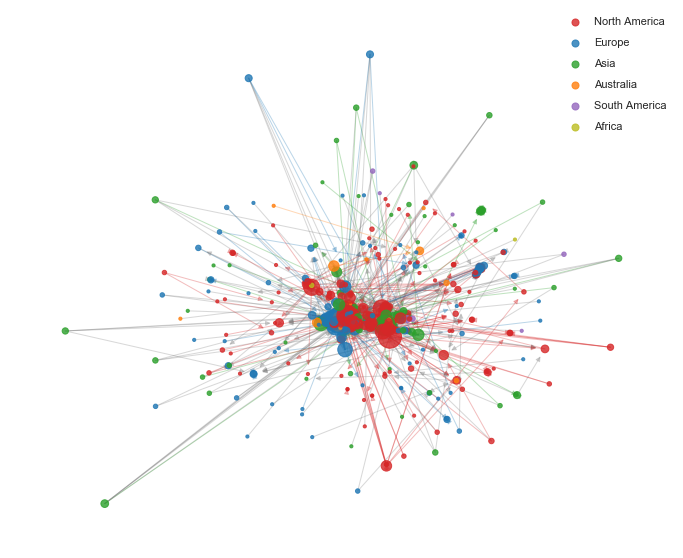

In [551]:
# create network with locations
location_G = nx.DiGraph()

location_G.add_nodes_from(location_df['user_name'].values)
pos_dict = dict(zip(location_df['user_name'].values, location_df['coordinates'].values))
nx.set_node_attributes(location_G, pos_dict,'pos')

for row in location_df.iterrows():
    edgelist = [(row[1]['user_name'], other_node) for other_node in row[1]['following_relevant_loc']]
    location_G.add_edges_from(edgelist)
    
# scale node-size according to degree
d = dict(location_G.degree)
node_sizes = [v * 10 for v in d.values()]

# color nodes according to location
continent_dict = dict(zip(location_df['user_name'].values, location_df['continent'].values))
nx.set_node_attributes(location_G, continent_dict,'continent')
colors = ['#d62728','#1f77b4','#2ca02c','#ff7f0e','#9467bd','#bcbd22']
node_colors = []
for node,continent in list(location_G.nodes('continent')):
    if continent == 'North America':
        node_colors.append(colors[0])
    elif continent == 'Europe':
        node_colors.append(colors[1])
    elif continent == 'Asia':
        node_colors.append(colors[2])
    elif continent == 'Australia':
        node_colors.append(colors[3])
    elif continent == 'South America':
        node_colors.append(colors[4])
    elif continent == 'Africa':
        node_colors.append(colors[5])

# color edges according to between-continent or not
edge_colors = []
for edge in location_G.edges:
    if location_G.nodes[edge[0]]['continent'] != location_G.nodes[edge[1]]['continent']:
        edge_colors.append('#7f7f7f')
    else:
        continent = location_G.nodes[edge[0]]['continent']
        if continent == 'North America':
            edge_colors.append(colors[0])
        elif continent == 'Europe':
            edge_colors.append(colors[1])
        elif continent == 'Asia':
            edge_colors.append(colors[2])
        elif continent == 'Australia':
            edge_colors.append(colors[3])
        elif continent == 'South America':
            edge_colors.append(colors[4])
        elif continent == 'Africa':
            edge_colors.append(colors[5])

# draw network
sns.set()
fig = plt.figure(figsize=(12,10))
nx.draw_networkx_nodes(location_G, positions, node_color=node_colors, alpha=0.8, node_size=node_sizes)
nx.draw_networkx_edges(location_G, positions, edge_color=edge_colors, alpha=0.3)

# labels
plt.scatter([], [], c=colors[0], alpha=0.8, s=50, label='North America')
plt.scatter([], [], c=colors[1], alpha=0.8, s=50, label='Europe')
plt.scatter([], [], c=colors[2], alpha=0.8, s=50, label='Asia')
plt.scatter([], [], c=colors[3], alpha=0.8, s=50, label='Australia')
plt.scatter([], [], c=colors[4], alpha=0.8, s=50, label='South America')
plt.scatter([], [], c=colors[5], alpha=0.8, s=50, label='Africa')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
plt.axis('off')
plt.show()

The network graph is plotted on a map in the following.

In [525]:
fig = plotly_graph(location_G,positions,'',True)
fig
#fig.write_html("data/map.html")

## 3.3 Community analysis

In this section, we start the analysis of the communities. 

### 3.3.1 Community detection

In [ ]:
# get communities
partition = community.best_partition(giant, random_state=26)
size = float(len(set(partition.values())))
print(f'Number of communities: {size}')

# get communities and sizes
values = [val for val in partition.values()]
bins, counts = np.unique(values, return_counts=True)
print('\nActual size of each community:')
print(sorted(counts))

# define bins 0-10,10-20, 20-30 etc
bins_def = [x*10 for x in list(range(16))]

print('\nBins:')
print(bins_def)

# create histogram
sns.set()
plt.figure(figsize=(10, 5))
plt.hist(counts, color=blue[2], bins=bins_def, alpha=0.8)
plt.xticks(bins_def)
plt.yticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
plt.xlabel('community size', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title('Distribution of community size', fontsize=16)
plt.show()

We choose to only look further into the 8 biggest communities. 

In [ ]:
top = np.argsort(counts)[-8::]
top_c = np.sort(counts)[-8::]
n_top = len(top)

In [ ]:
def get_com(comnum):
    
    com = [k for k,v in zip(partition.keys(), partition.values()) if v==comnum]   
    df_com1 = df[df['user_name'].isin(com)]

    # store the network of users with DiGraph
    G = nx.DiGraph()
    G.add_nodes_from(df_com1['user_name'].values)

    for row in df_com1.iterrows():
        z = [(row[1]['user_name'], other_node) for other_node in row[1]['following_relevant']]
        G.add_edges_from(z)

    # extract giant connected component 
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    GCC = G.subgraph(largest_cc)
    giant = GCC.to_undirected()
    
    
    df_com1['in_degree'] = df['user_name'].apply(lambda x: G.in_degree(x))
    df_com1['out_degree'] = df['user_name'].apply(lambda x: G.out_degree(x))
    df_com1['degree'] = df['user_name'].apply(lambda x: G.degree(x))
    
    
    return giant,df_com1

In [ ]:
# make dataframe with communities, top users and languages

df_com = pd.DataFrame()
df_com['Number'] = top
df_com['Nodes'] = top_c

names = []
names2 = []
for i in range(len(df_com)):
    com_df = get_com(i)[1].reset_index(drop=True)
    
    langs = np.unique(list(com_df['main_language']),return_counts=True)[0]
    c_langs = np.unique(list(com_df['main_language']),return_counts=True)[1]
    name = langs[np.argsort(c_langs)[-3:]]
  
    names.append('-'.join(name)) # name communities    
    
    top3 = list(np.argsort(com_df['degree'])[-3:]) # get top three most connected characters
    name2 = [com_df['user_name'][idx] for idx in top3][::-1]
    connects = [com_df['degree'][idx] for idx in top3][::-1]
    
  
    names2.append('-'.join(name2))
      
df_com['Top_languages'] = names
df_com['Top_usernames'] = names2

# add sentiment variable
df_com['Sentiment_desc'] = [df[df['user_name'].isin(get_com(i)[0])]['Sentiment_desc'].mean() for i in range(len(df_com))]
df_com['Sentiment_bio'] = [df[df['user_name'].isin(get_com(i)[0])]['Sentiment_bio'].mean() for i in range(len(df_com))]
df_com['Avg stars'] = [df[df['user_name'].isin(get_com(i)[0])]['total_stars'].mean() for i in range(len(df_com))]
df_com['Avg stars'] = [df[df['user_name'].isin(get_com(i)[0])]['total_stars'].mean() for i in range(len(df_com))]


df_com = df_com.round(3)
#df_com.sort_values(by='Sentiment_desc',ascending=False).reset_index(drop=True)
df_com

### 3.3.2 Visualisation

In [ ]:
def graph_detail(comnum):
    giant2 = get_com(comnum)[0]
    positions = forceatlas2.forceatlas2_networkx_layout(giant2, pos=None, iterations=10)  
    
    d = dict(giant2.degree)
    sizes = [v *10 for v in d.values()]
    
    return giant2, positions,sizes

In [254]:

graphs_list = []
positions_list = []
sizes_list =[]

for t in top:    
    g1 = graph_detail(t)[0]
    pos1 = graph_detail(t)[1]
    size1 =  graph_detail(t)[2]
  
    graphs_list.append(g1)
    positions_list.append(pos1)
    sizes_list.append(size1)


TypeError: 'int' object is not iterable

In [255]:
# set style, figure size and title
sns.set()

plt.figure(figsize=(20,20))

for i in range(n_top):
    
    comnum=i
    
    plt.subplot(4,2,i+1)
     
    # set style, figure size and axis off
 #   jtplot.style('chesterish')
 

    # draw network
    nx.draw_networkx_nodes(graphs_list[comnum], positions_list[comnum], node_color=blue[5], alpha=0.8, node_size=sizes_list[comnum])
    nx.draw_networkx_edges(graphs_list[comnum], positions_list[comnum], edge_color=blue[2], alpha=0.3)
   # plt.scatter([], [], c=blue[5], alpha=0.9, s=100, label='Github users')
    
   # plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
    plt.axis('off')
    plt.title(f'Community {top[i]}')

plt.show()

NameError: name 'n_top' is not defined

<Figure size 1440x1440 with 0 Axes>

In [256]:
for i in range(n_top):
    fig_com = plotly_graph(graphs_list[i],positions_list[i],f'Community {top[i]}',False)
    fig_com.write_html(f"data/file{top[i]}.html")


NameError: name 'n_top' is not defined

In [257]:
fig_com

NameError: name 'fig_com' is not defined

### 3.3.3 Text analysis


In this part, we analyze the importance of words in each community using TF-IDF. Each community is described with a dcoument containing eiter all descriptions, bios or languages. 

#### Important words (TF-IDF)

In [258]:
def TF_IDF(col,cat):
    
    if cat=='community':
    # get tokens and TFs for each community
        tokens = [list(get_TF(get_com(i)[1],col)[0].keys())for i in range(n_top)]
        TFs = [list(get_TF(get_com(i)[1],col)[0].values()) for i in range(n_top)]

        # define documents
        Docs = [f'Doc{i}' for i in range(n_top)]

    elif cat=='years':
        tokens = [list(get_TF(get_year([y])[0],col)[0].keys())for y in years]
        TFs = [list(get_TF(get_year([y])[0],col)[0].values()) for y in years]

        # define documents
        Docs = [f'Doc{i}' for i in range(len(years))]


    DF = pd.DataFrame()

    for i in range(n_top):
        DF1 = pd.DataFrame()
        DF1['Words'] = tokens[i]
        DF1[Docs[i]] = TFs[i]    
        DF = pd.concat([DF,DF1])

    DF_group = DF.groupby(['Words']).sum().reset_index()
    DF_group.replace(0, np.nan, inplace=True)

    # find document frequncy for each word
    DF_group['DF'] = DF_group[DF_group.columns[1:]].count(axis=1)

    # then calculate IDF
    DF_group['IDF'] = [np.log(n_top)/(nt+1)+1 for nt in DF_group['DF']]

    # lastly calculate TF-IDF for each word in each document
    for i in range(n_top):
        DF_group[f'{Docs[i]}_TFIDF'] = DF_group[Docs[i]]*DF_group['IDF']

    return DF_group

In [259]:
def create_wordcloud(num,col,cat):
    
    DF_group = TF_IDF(col,cat)
    Com = DF_group[~DF_group[f'Doc{num}_TFIDF'].isna()][['Words',f'Doc{num}_TFIDF']].reset_index()  
    Freq = dict(zip(Com['Words'],Com[f'Doc{num}_TFIDF']))

    numnum = top[num]   
    com_df = get_com(numnum)[1].reset_index(drop=True)


    # create WordCloud
    wordcloud = WordCloud(background_color='white',                 
                          collocations = False                 
                         ).generate_from_frequencies(Freq)

    img = plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off")


In [260]:
sns.set()
plt.figure(figsize=(20,40))
# create subplots
for i in range(n_top):
    plt.subplot(8,2,(i*2)+1)
    create_wordcloud(i,'used_languages','community') 
    plt.axis("off")
    plt.title(f'Community {top[i]}')
    plt.subplot(8,2,(i*2)+2)   
    create_wordcloud(i,'bio','community')
    plt.title(f'Community {top[i]}')
 
plt.tight_layout()
plt.show()

NameError: name 'n_top' is not defined

<Figure size 1440x2880 with 0 Axes>

#### Sentiment analysis

In [261]:
_,_ = happy_sad(df_com,'Sentiment_desc',3,'Top_usernames')

NameError: name 'df_com' is not defined

In [262]:
_,_ = happy_sad(df_com,'Sentiment_bio',3,'Top_usernames')

NameError: name 'df_com' is not defined

# 4 Discussion
*Think critically about creation. What went well? What is still missing? What could be improved?, Why?*

# 5 Contributions


In [ ]:
ct = pd.DataFrame({'Section 1' : ["", "", "", "", "", "", "", "", ""], 
                   'Section 2' : ["", "", "", "", "", "", "", "", ""],
                   'Section 3' : ["", "", "", "", "", "", "", "", ""],
                   'Section 4' : ["", "", "", "", "", "", "", "", ""]}, 
                   index =['Part 1','Part 2.1','Part 2.2','Part 3.1','Part 3.2','Part 3.3','Part 3.4','Part 3.5','Part 4']) 
ct